# 0. Importing Packages

In [1]:
%matplotlib notebook

import time
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
import copy
from astropy.convolution import convolve
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import Gaussian2DKernel
from scipy.special import erf
from scipy.stats import sigmaclip
from scipy.optimize import minimize
import emcee
import pandas as pd
import warnings
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec 
from scipy.stats import truncnorm
from scipy.stats import skew
from scipy.stats import kurtosis
import tqdm
import init_cfg as ic

# 1. Loading IFU Data

In [2]:
# ----- Basic parameters ----- #
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
redshift = ic.redshift
dist_lum = cosmo.luminosity_distance(redshift).value*1.0e+6    # pc

wav_NII_6548 = 6549.86    # Angstrom (SDSS)
wav_NII_6584 = 6585.27    # Angstrom (SDSS)
wav_Ha = 6564.61    # Angstrom (SDSS)
wav_SII_6717 = 6718.29    # Angstrom (SDSS)
wav_SII_6731 = 6732.67    # Angstrom (SDSS)
wav_OII_3727 = 3727.092    # Angstrom (SDSS)
wav_OII_3729 = 3729.875    # Angstrom (SDSS)
wav_OIII_4959 = 4960.295    # Angstrom (SDSS)
wav_OIII_5007 = 5008.240    # Angstrom (SDSS)
c = 2.99792e+5    # km/s

# ----- Loading Voronoi binned data ----- #
dir_vbin = 'vorbin/'
vb = np.load(dir_vbin+'vorbin_array.npz')
# wav, sci, var, cont
wav_obs = vb['wav']
wav_res = wav_obs / (1.0+redshift)
binned_spectrum = vb['sci']
binned_variance = vb['var']
binned_continuum = vb['cont']
data_vbin = fits.getdata(dir_vbin+'vbin.fits').astype('int')
nbin = binned_spectrum.shape[1]

In [3]:
binned_spectrum.shape

(4591, 431)

In [4]:
data0 = binned_spectrum - binned_continuum
vari0 = binned_variance
cont0 = binned_continuum

dat = data0 * (1.0+redshift)
var = vari0 * (1.0+redshift)**2.0
cont = cont0 * (1.0+redshift)

# Reading the spectral resolution fitting results
par, e_par = np.loadtxt('relation_wav_R.txt').T

In [5]:
print(np.unique(data_vbin, return_counts=True))
binNum, binNpix = np.unique(data_vbin, return_counts=True)
print(0.1*np.sum((binNpix == 1)))
print(0.1*np.sum((binNpix <= 4)))

(array([-99,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

## 1.1. Retrieving maximum spectrum

In [6]:
wavcut = fits.getdata("diagram/wavcut_Halpha+NII.fits")
yInd, xInd = np.unravel_index(np.argmax(wavcut), wavcut.shape)
# yInd2, xInd2 = 30, 38    # non-contaminated region
n_bin = data_vbin[yInd, xInd]
print("Maximum intensity bin")
print(f"Bin {n_bin:d}: (x, y) = ({xInd:d}, {yInd:d})")

maximum_spectrum = dat[:, n_bin]
maximum_variance = var[:, n_bin]
maximum_continuum = cont[:, n_bin]

Maximum intensity bin
Bin 0: (x, y) = (32, 29)


## 1.2. Retrieving integrated spectrum with the bin's order

In [7]:
n_integrate = 16
integrated_spectrum = np.sum(dat[:, :n_integrate], axis=1)
integrated_variance = np.sum(var[:, :n_integrate], axis=1)
integrated_continuum = np.sum(cont[:, :n_integrate], axis=1)

## 1.3. Retrieving integrated spectrum within a circle

In [8]:
fin_cb = 'bfcube_3D.fits'

d_sci, h_sci = fits.getdata(fin_cb, ext=1, header=True)
d_var, h_var = fits.getdata(fin_cb, ext=2, header=True)

d_sci[:, 0, :] = 0.
d_sci[:, :, 0] = 0.
d_sci[:, -1, :] = 0.
d_sci[:, :, -1] = 0.

d_sci2 = d_sci * (1+redshift)
d_var2 = d_var * (1+redshift)**2

In [9]:
from photutils.aperture import CircularAperture as CAp
rad = 4
ap = CAp((xInd, yInd), r=rad)
ap_msk = ap.to_mask(method='exact')
msk = ap_msk.to_image((d_sci.shape[1], d_sci.shape[2]))
print(f"Area: {np.sum(msk):.4f} = {np.pi*rad**2:.4f}? ", np.sum(msk) == np.pi*rad**2)

circular_spectrum = np.sum(d_sci2*msk, axis=(1, 2))
circular_variance = np.sum(d_var2*msk, axis=(1, 2))
print(circular_spectrum.shape)

Area: 50.2655 = 50.2655?  True
(4591,)


<IPython.core.display.Javascript object>


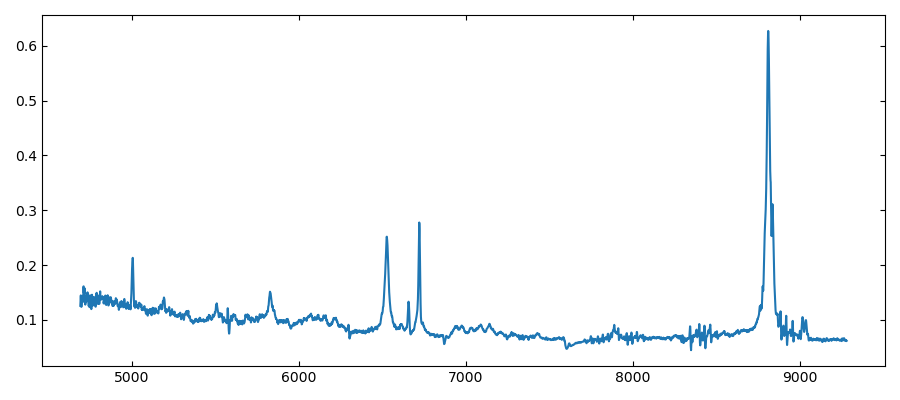

In [10]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, circular_spectrum)
plt.tight_layout()

### 1.3.1. Continuum subtraction for the circular spectrum

<IPython.core.display.Javascript object>


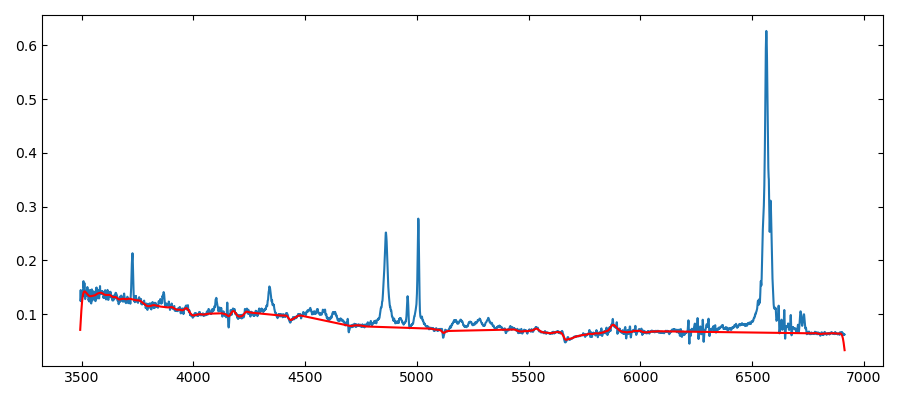

In [11]:
# ----- Continuum fitting ----- #
cont_width = 5  # AA
kernel_width = 10  # AA
sig1, sig2 = 3.0, 4.0  # For sigma clipping

# Wavelength masking range (copied from contfit_init.ipynb)
wav_msk = np.array([[4975, 5025],  # [OII]
                    [5150, 5225],   # [NeIII]
                    [5450, 5550],   # H delta
                    [5700, 5900],   # H gamma
                    [6000, 6320],   # noisy? region
                    [6400, 6800],   # H beta + [OIII]4959/5007
                    [6900, 7300],   # noisy? region
                    [8150, 9075]])   # [NII] + H alpha + [SII]6717/31

# Interpolation
spec_int = copy.deepcopy(circular_spectrum)
for j in np.arange(wav_msk.shape[0]):
    spx_l = np.abs(wav_obs - wav_msk[j,0]).argmin()
    spx_r = np.abs(wav_obs - wav_msk[j,1]).argmin()

    c_l, lo_l, up_l = sigmaclip(spec_int[spx_l-round(cont_width/ic.wav_intv):spx_l], sig1, sig1)  # 20 AA
    c_r, lo_r, up_r = sigmaclip(spec_int[spx_r+1:spx_r+1+round(cont_width/ic.wav_intv)], sig1, sig1)  # 20 AA

    cont_l = c_l.mean()
    cont_r = c_r.mean()

#     spec_int[spx_l:spx_r+1] = 0.5*(cont_l + cont_r)
    spec_int[spx_l:spx_r+1] = cont_l + \
    ((cont_r-cont_l)/(wav_obs[spx_r]-wav_obs[spx_l]))*(wav_obs[spx_l:spx_r+1]-wav_obs[spx_l])

# Sigma clipping
clipped, lower, upper = sigmaclip(spec_int, sig2, sig2)
spec_int_clipped = copy.deepcopy(spec_int)
spec_int_clipped[spec_int < lower] = clipped.mean()
spec_int_clipped[spec_int > upper] = clipped.mean()

# Smoothing spectra
g = Gaussian1DKernel(stddev = round(kernel_width/ic.wav_intv))  # 10 AA
spec_filt = convolve(spec_int_clipped, g)  # spec_int OR spec_int_clipped

# Plotting & saving results
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_res, circular_spectrum)
ax.plot(wav_res, spec_filt, '-', color='red')
plt.tight_layout()
plt.savefig("subcircular_0.png", dpi=300)

subcircular_spectrum = circular_spectrum - spec_filt
subcircular_variance = circular_variance
subcircular_continuum = spec_filt

In [12]:
mode = "subcircular"
# "maximum" OR "integrated" OR "subcircular"

exec("fit_spectrum = copy.deepcopy("+mode+"_spectrum)")
exec("fit_variance = copy.deepcopy("+mode+"_variance)")
exec("fit_continuum = copy.deepcopy("+mode+"_continuum)")

In [13]:
# df = pd.DataFrame(data = {'wav_res':wav_res,
#                           'flux_density':circular_spectrum,
#                           'variance':subcircular_variance,
#                           'continuum':subcircular_continuum})
# df.to_csv("GMOS_data.csv")

<IPython.core.display.Javascript object>


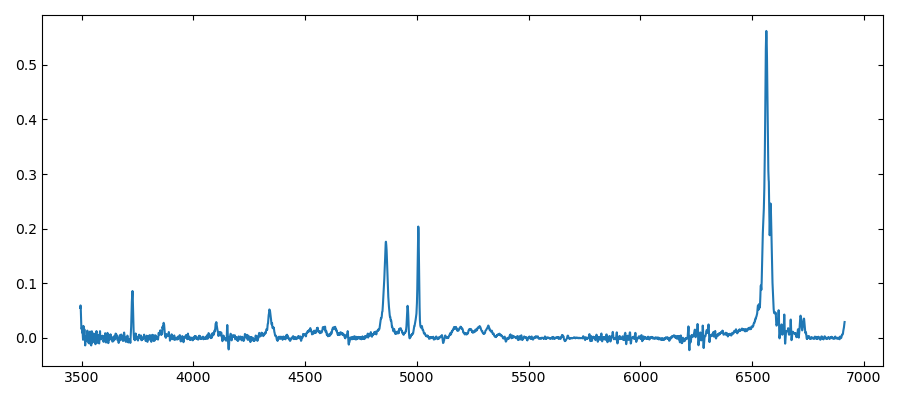

In [14]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_res, fit_spectrum)
plt.tight_layout()

# 2. Basic Setting of Line Fitting

In [15]:
np.random.seed(0)
maxfev = 2000

In [16]:
from scipy.optimize import curve_fit
from scipy.special import erf

def gauss_cdf_scale(x, mu, sigma, flux_scale):
    dx = x[1] - x[0]
    v1 = erf((x-mu+0.5*dx)/(np.sqrt(2.0)*sigma))
    v2 = erf((x-mu-0.5*dx)/(np.sqrt(2.0)*sigma))
    return flux_scale*(v1-v2)/(2.0*dx)

def multin_gauss_cdf_scale(x, *pars, n=2, n_broad=0):
    g_i = 0
    n_narrow = n - n_broad
    for i in np.arange(n):
        if ((n_narrow > 0) & (i < n_narrow)):
            g_i += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
        elif (n_narrow == 0):
            g_i += gauss_cdf_scale(x, pars[3*i], pars[3*i+1], pars[3*i+2])
        else:
            i_b = i-(n_narrow)
            npn = 2*n_narrow
            g_i += gauss_cdf_scale(x, pars[npn+3*i_b+1], pars[npn+3*i_b+2], pars[npn+3*i_b+3])
    return g_i

In [17]:
def line_par(line_numbers, broad_component = False):

    if (line_numbers == 0):
        nlines, nbroad = 1, 0  # 2, 0
        line_names = ['OII3727']#, 'OII3729']
        line_wav = [3727.092]#, 3729.875]
        line_sigma = [3.0]
        wav_fit = [3720.0, 3740.0]
    
    if (line_numbers == 1):
        if broad_component:
            nlines, nbroad = 2, 1
            line_names = ['Hbeta', 'Broad1_1']
            line_wav = [4862.68, 4862.68]
            line_sigma = [3.0, 20.0]
            wav_fit = [4810.0, 4910.0]
        else:
            nlines, nbroad = 1, 0
            line_names = ['Hbeta']
            line_wav = [4862.68]
            line_sigma = [3.0]
            wav_fit = [4855.0, 4870.0]

    if (line_numbers == 2):
        if broad_component:
            nlines, nbroad = 3, 1
            line_names = ['OIII4959', 'OIII5007', 'Broad2_1']
            line_wav = [4960.295, 5008.240, 5008.240]
            line_sigma = [3.0, 20.0]
            wav_fit = [4940.0, 5040.0]
        else:    
            nlines, nbroad = 2, 0
            line_names = ['OIII4959', 'OIII5007']
            line_wav = [4960.295, 5008.240]
            line_sigma = [3.0]
            wav_fit = [4950.0, 5015.0]        

    if (line_numbers == 3):
        if broad_component:
            nlines, nbroad = 4, 1
            line_names = ['NII6548', 'Halpha', 'NII6584', 'Broad3_1']
            line_wav = [6549.86, 6564.61, 6585.27, 6564.61]
            line_sigma = [3.0, 30.0]
            wav_fit = [6500.0, 6625.0]
        else:
            nlines, nbroad = 3, 0
            line_names = ['NII6548', 'Halpha', 'NII6584']
            line_wav = [6549.86, 6564.61, 6585.27]
            line_sigma = [3.0]
            wav_fit = [6540.0, 6595.0]

    if (line_numbers == 4):
        nlines, nbroad = 2, 0
        line_names = ['SII6717', 'SII6731']
        line_wav = [6718.29, 6732.67]
        line_sigma = [3.0]
        wav_fit = [6710.0, 6740.0]

    if (line_numbers == 5):
        nlines, nbroad = 1, 0
        line_names = ['OI6300']
        line_wav = [6302.046]
        line_sigma = [3.0]
        wav_fit = [6295.0, 6310.0]

    if (line_numbers == 6):
        if broad_component:
            nlines, nbroad = 4, 1
            line_names = ['Hbeta', 'OIII4959', 'OIII5007', 'Broad6_1']
            line_wav = [4862.68, 4960.295, 5008.240, 4862.68]
            line_sigma = [3.0, 10.0]
            wav_fit = [4820.0, 5040.0]
        else:
            nlines, nbroad = 3, 0
            line_names = ['Hbeta', 'OIII4959', 'OIII5007']
            line_wav = [4862.68, 4960.295, 5008.240]
            line_sigma = [3.0]
            wav_fit = [4840.0, 5020.0]
        
    line_model = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nlines, n_broad=nbroad)
    
    return [nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model]

f = open('linefit_integrated.txt','w')
f.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq  eqw\n')
f.close()

broad = True
if broad:
    g = open('linefit_integrated_broad.txt','w')
    g.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq  flxsum_scale\n')
    g.close()

# 3. Emission Line Fitting

In [18]:
def line_fit(line_numbers, n_fit=1000, maxfev=2000, write=True, broad_component=False,
             mode='automatic', mask=False, xtot=wav_res, ytot=fit_spectrum, e2_ytot=fit_variance, **kwargs):
    # Line fitting: Monte Carlo simulation of curve_fit    

#     if (mode == 'automatic'):
    lp = line_par(line_numbers, broad_component=broad_component)
    nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = lp        

    if (mode == 'manual'):
        nlines     = kwargs['nlines']
        nbroad     = kwargs['nbroad']
        line_names = kwargs['line_names']
        line_wav   = kwargs['line_wav']
        line_sigma = kwargs['line_sigma']
        wav_fit    = kwargs['wav_fit']
        line_model = kwargs['line_model']
        if mask:
            mask_range = kwargs['mask_range']

    spx_fit = [np.abs(xtot-wav_fit[0]).argmin(),
               np.abs(xtot-wav_fit[1]).argmin()]
    x_bin = xtot[1] - xtot[0]
    x_wav = xtot[spx_fit[0]:spx_fit[1]+1]    
    
    if mask:
        idx_nmsk = []
        for i in np.arange(np.shape(mask_range)[0]):
            if (i == 0):
                idx_nmsk.extend(list(range(0, np.abs(x_wav-mask_range[i][0]).argmin())))
            else:
                idx_nmsk.extend(list(range(np.abs(x_wav-mask_range[i-1][1]).argmin(),
                                np.abs(x_wav-mask_range[i][0]).argmin())))
        idx_nmsk.extend(list(range(np.abs(x_wav-mask_range[-1][1]).argmin(), len(x_wav))))

        x_wav = x_wav[idx_nmsk]
        y_loc = ytot[spx_fit[0]:spx_fit[1]+1][idx_nmsk]
        y_var = e2_ytot[spx_fit[0]:spx_fit[1]+1][idx_nmsk]
    
    else:
        y_loc = ytot[spx_fit[0]:spx_fit[1]+1]
        y_var = e2_ytot[spx_fit[0]:spx_fit[1]+1]

    x_fit = np.log(x_wav)
    flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

    mpopt = []
    for i in tqdm.trange(n_fit):
        y_dat = np.random.normal(y_loc, np.sqrt(y_var))
        outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
        y_dat[outliers] = y_loc[outliers]
        y_fit = x_wav * y_dat
        
        param = []
#         param = [line_sigma[0] / line_wav[0]]
        for j in np.arange(nlines):
            if (nlines == nbroad):
                param += [np.log(line_wav[j]),
                          line_sigma[0] / line_wav[j],
                          flx_scale0 / nlines]
            elif (j < nlines-nbroad):
                if (j == 0):
                    param += [line_sigma[0] / line_wav[0]]
                    param += [np.log(line_wav[j]), flx_scale0 / nlines]
                else:
                    param += [np.log(line_wav[j]), flx_scale0 / nlines]
            else:
                param += [np.log(line_wav[j]),
                          line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                          flx_scale0 / nlines]
                
        popt, pcov = curve_fit(line_model, x_fit, y_fit, param, maxfev=maxfev)
        perr = np.sqrt(np.diag(pcov))
        mpopt.append(popt)

    mpar = np.mean(mpopt, axis=0)
    e_mpar = np.std(mpopt, axis=0)


    # Printing & writing the results
    for i in np.arange(nlines):
        if ((i == 0) & (nlines > nbroad)):
            print("----- Narrow components -----")
        if ((i == nlines-nbroad) | (nlines == nbroad)):
            print("----- Broad components -----")
            
        if (i < nlines-nbroad):
            mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
            vsig, e_vsig = c*mpar[0], c*e_mpar[0]
            flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
            F1 = gauss_cdf_scale(np.log(wav_res), mpar[2*i+1], mpar[0], mpar[2*i+2]) / wav_res
        elif (nlines == nbroad):
            mu, e_mu = np.exp(mpar[3*i]), np.exp(mpar[3*i])*e_mpar[3*i]
            vsig, e_vsig = c*mpar[3*i+1], c*e_mpar[3*i+1]
            flux, e_flux = mpar[3*i+2], e_mpar[3*i+2]
            F1 = gauss_cdf_scale(np.log(wav_res), mpar[3*i], mpar[3*i+1], mpar[3*i+2]) / wav_res            
        else:
            i_b = i-(nlines-nbroad)
            npn = 2*(nlines-nbroad)
            mu, e_mu = np.exp(mpar[npn+3*i_b+1]), np.exp(mpar[npn+3*i_b+1])*e_mpar[npn+3*i_b+1]
            vsig, e_vsig = c*mpar[npn+3*i_b+2], c*e_mpar[npn+3*i_b+2]
            flux, e_flux = mpar[npn+3*i_b+3], e_mpar[npn+3*i_b+3]
            F1 = gauss_cdf_scale(np.log(wav_res), mpar[npn+3*i_b+1], mpar[npn+3*i_b+2],
                                 mpar[npn+3*i_b+3]) / wav_res

        print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

        print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
        lsig = mu * vsig / c
        e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
        print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

        specR = par[0]+par[1]*mu*(1+redshift)
        e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
        print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

        print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")
        
        eqw = np.trapz(-F1/fit_continuum, x=wav_res)
        print(line_names[i]+f" equivalent width: {eqw:.2f} Angstrom")

#         spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
#                     np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
        chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
        dof = len(y_loc) - len(param)
        rchisq = np.sum(chisq) / dof
#         dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
#         rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
        print(f"Total reduced chi-square: {rchisq:.2f}")
        print("\n")
        
    if write:
        f = open('linefit_integrated.txt','a')
        g = open('linefit_integrated_broad.txt','a')
        for i in np.arange(nlines):
            if (line_names[i][:5] != 'Broad'):
                f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
                f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
                f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
                f.write(f"{specR:.2f}  {e_specR:.2f}  ")
                f.write(f"{flux:.2e}  {e_flux:.2e}  ")
                f.write(f"{rchisq:.2f}  ")
                f.write(f"{eqw:.2f}\n")
            else:
                g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
                g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
                g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
                g.write(f"{specR:.2f}  {e_specR:.2f}  ")
                g.write(f"{flux:.2e}  {e_flux:.2e}  ")
                g.write(f"{rchisq:.2f}  ")
                g.write(f"{flx_scale0:.2e}\n")
        f.close()
        g.close()


    # Figure
    fig, ax = plt.subplots(figsize=(7,5))
    ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
    ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Flux')
    ax.plot(xtot, ytot, color='C0')
    if (nbroad >= 1):
        for i in np.arange(nlines):
            if (i < nlines-nbroad):
                y_plt = gauss_cdf_scale(xtot, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
                lc, ls = 'C1', '-'
            elif (nlines == nbroad):
                y_plt = gauss_cdf_scale(xtot, np.exp(mpar[3*i]), mpar[3*i+1]*np.exp(mpar[3*i]), mpar[3*i+2])
                lc, ls = 'C3', '--'
            else:
                i_b = i-(nlines-nbroad)
                npn = 2*(nlines-nbroad)
                y_plt = gauss_cdf_scale(xtot, np.exp(mpar[npn+3*i_b+1]),
                                        mpar[npn+3*i_b+2]*np.exp(mpar[npn+3*i_b+1]), mpar[npn+3*i_b+3])
                lc, ls = 'C3', '--'
            ax.plot(xtot, y_plt, color=lc, linestyle=ls, alpha=0.75)                
    ax.plot(xtot, ytot - line_model(np.log(xtot), *mpar) / xtot - 0.7*np.abs(np.max(y_loc)),
            color='C2', alpha=0.75)
    ax.plot(xtot, line_model(np.log(xtot), *mpar) / xtot, color='C6', alpha=0.9)
    plt.tight_layout()
    plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

    # Saving broad components
    b_var = []
    for i in np.arange(nbroad):
        if (nlines == nbroad):
            mpar_b = mpar[3*i:3*(i+1)]
        else:
            mpar_b = mpar[2*(nlines-nbroad)+(3*i+1):2*(nlines-nbroad)+(3*i+4)]
        b_var.extend(mpar_b)
    print(b_var)
        
    return [mpar, e_mpar]

## 3.1. ${\rm H\alpha+[NII]}\lambda\lambda6548,6584$

### 3.1.1. Automatic

100%|██████████| 100/100 [00:02<00:00, 42.56it/s]

----- Narrow components -----
NII6548 mean: 6549.354 +/- 0.077 Angstrom
NII6548 sigma: 272.69 +/- 0.834 km/s
NII6548 sigma: 5.957 +/- 0.018 Angstrom
NII6548 R: 1197.39 +/- 44.72
NII6548 flux: 1.53e+00 +/- 1.91e-02
NII6548 equivalent width: -23.52 Angstrom
Total reduced chi-square: 17.48


Halpha mean: 6563.573 +/- 0.021 Angstrom
Halpha sigma: 272.69 +/- 0.834 km/s
Halpha sigma: 5.970 +/- 0.018 Angstrom
Halpha R: 1200.00 +/- 44.78
Halpha flux: 7.04e+00 +/- 3.02e-02
Halpha equivalent width: -108.02 Angstrom
Total reduced chi-square: 17.48


NII6584 mean: 6581.540 +/- 0.045 Angstrom
NII6584 sigma: 272.69 +/- 0.834 km/s
NII6584 sigma: 5.986 +/- 0.018 Angstrom
NII6584 R: 1203.30 +/- 44.85
NII6584 flux: 2.38e+00 +/- 1.77e-02
NII6584 equivalent width: -36.67 Angstrom
Total reduced chi-square: 17.48


----- Broad components -----
Broad3_1 mean: 6559.974 +/- 0.188 Angstrom
Broad3_1 sigma: 1662.38 +/- 14.816 km/s
Broad3_1 sigma: 36.376 +/- 0.324 Angstrom
Broad3_1 R: 1199.34 +/- 44.76
Broad3_1 fl

<IPython.core.display.Javascript object>


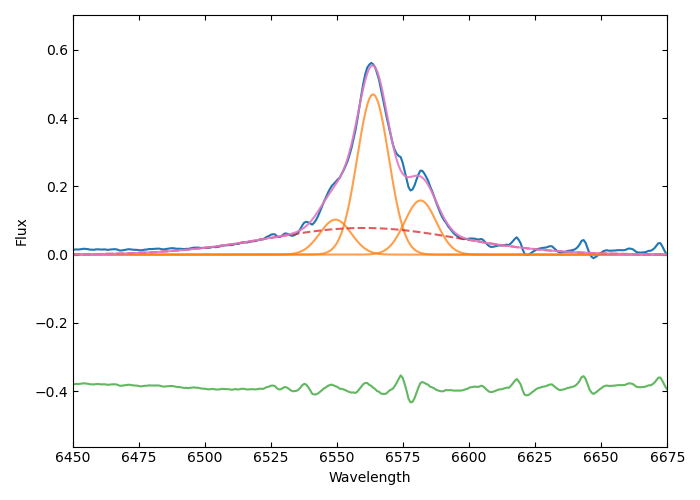

[8.78874193483329, 0.005545105498102464, 7.127892778764818]


[array([9.09582266e-04, 8.78712175e+00, 1.53406031e+00, 8.78929046e+00,
        7.03696571e+00, 8.79202405e+00, 2.38490312e+00, 8.78874193e+00,
        5.54510550e-03, 7.12789278e+00]),
 array([2.78293160e-06, 1.17466035e-05, 1.90993654e-02, 3.12520719e-06,
        3.02179307e-02, 6.84509305e-06, 1.77068154e-02, 2.87161655e-05,
        4.94219486e-05, 4.71418186e-02])]

In [19]:
line_fit(3, n_fit=100, maxfev=2000, write=False, broad_component=True)

### 3.1.2. Manual

100%|██████████| 100/100 [00:01<00:00, 53.56it/s]

----- Narrow components -----
NII6548 mean: 6549.149 +/- 0.078 Angstrom
NII6548 sigma: 275.25 +/- 0.855 km/s
NII6548 sigma: 6.013 +/- 0.019 Angstrom
NII6548 R: 1197.35 +/- 44.72
NII6548 flux: 1.61e+00 +/- 1.80e-02
NII6548 equivalent width: -24.73 Angstrom
Total reduced chi-square: 16.25


Halpha mean: 6563.566 +/- 0.021 Angstrom
Halpha sigma: 275.25 +/- 0.855 km/s
Halpha sigma: 6.026 +/- 0.019 Angstrom
Halpha R: 1200.00 +/- 44.78
Halpha flux: 7.21e+00 +/- 2.67e-02
Halpha equivalent width: -110.69 Angstrom
Total reduced chi-square: 16.25


NII6584 mean: 6581.578 +/- 0.041 Angstrom
NII6584 sigma: 275.25 +/- 0.855 km/s
NII6584 sigma: 6.043 +/- 0.019 Angstrom
NII6584 R: 1203.30 +/- 44.85
NII6584 flux: 2.48e+00 +/- 1.69e-02
NII6584 equivalent width: -38.14 Angstrom
Total reduced chi-square: 16.25


----- Broad components -----
Broad3_1 mean: 6558.926 +/- 0.226 Angstrom
Broad3_1 sigma: 1816.33 +/- 14.080 km/s
Broad3_1 sigma: 39.738 +/- 0.308 Angstrom
Broad3_1 R: 1199.15 +/- 44.76
Broad3_1 fl

<IPython.core.display.Javascript object>


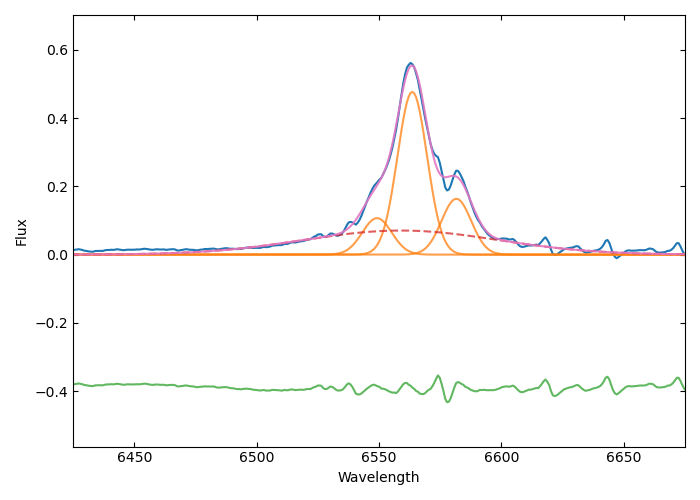

[8.788582188649235, 0.006058645439432257, 7.02953717133594]


In [20]:
nl, nb = 4, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['NII6548', 'Halpha', 'NII6584', 'Broad3_1'],# 'Broad3_2', 'Broad3_2'],
           'line_wav':[6549.86, 6564.61, 6585.27, 6560.0],# 6564.61, 6564.61],
           'line_sigma':[3.0, 35.0], 'wav_fit':[6475.0, 6625.0],#[6450.0, 6625.0],
           'line_model':lm}

s1, e_s1 = line_fit(3, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=False, xtot=wav_res, ytot=fit_spectrum, e2_ytot=fit_variance, **kw_lpar)
s1_b, e_s1_b = s1[2*(nl-nb)+1:], e_s1[2*(nl-nb)+1:]

100%|██████████| 100/100 [00:02<00:00, 42.56it/s]

----- Narrow components -----
NII6548 mean: 6547.159 +/- 0.106 Angstrom
NII6548 sigma: 169.89 +/- 1.675 km/s
NII6548 sigma: 3.710 +/- 0.037 Angstrom
NII6548 R: 1196.99 +/- 44.71
NII6548 flux: 3.98e-01 +/- 3.24e-02
NII6548 equivalent width: -6.11 Angstrom
Total reduced chi-square: 9.69


Halpha mean: 6562.739 +/- 0.043 Angstrom
Halpha sigma: 169.89 +/- 1.675 km/s
Halpha sigma: 3.719 +/- 0.037 Angstrom
Halpha R: 1199.85 +/- 44.77
Halpha flux: 1.77e+00 +/- 4.16e-02
Halpha equivalent width: -27.13 Angstrom
Total reduced chi-square: 9.69


NII6584 mean: 6584.245 +/- 0.043 Angstrom
NII6584 sigma: 169.89 +/- 1.675 km/s
NII6584 sigma: 3.731 +/- 0.037 Angstrom
NII6584 R: 1203.79 +/- 44.86
NII6584 flux: 1.12e+00 +/- 2.46e-02
NII6584 equivalent width: -17.29 Angstrom
Total reduced chi-square: 9.69


----- Broad components -----
Broad3_1 mean: 6564.194 +/- 0.058 Angstrom
Broad3_1 sigma: 465.63 +/- 6.068 km/s
Broad3_1 sigma: 10.195 +/- 0.133 Angstrom
Broad3_1 R: 1200.11 +/- 44.78
Broad3_1 flux: 7.9

<IPython.core.display.Javascript object>


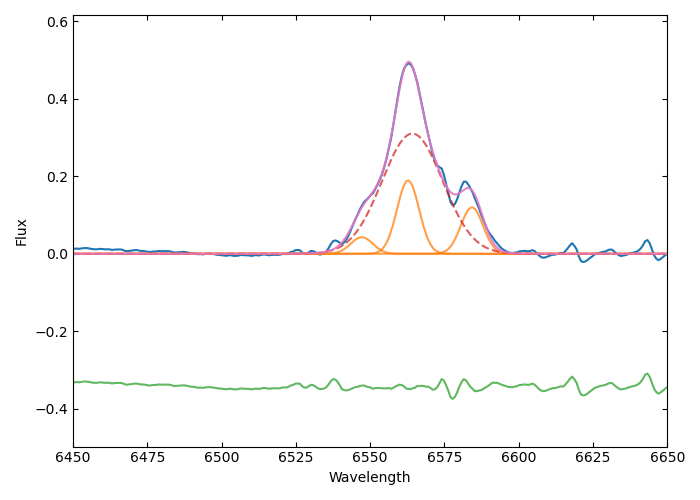

[8.789384981167878, 0.0015531606026526644, 7.923842084633391]


In [21]:
ysub = fit_spectrum - gauss_cdf_scale(wav_res, np.exp(s1_b[0]), s1_b[1]*np.exp(s1_b[0]), s1_b[2])

nl, nb = 4, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['NII6548', 'Halpha', 'NII6584', 'Broad3_1'],# 'Broad3_2', 'Broad3_2'],
           'line_wav':[6549.86, 6564.61, 6585.27, 6564.61],# 6564.61, 6564.61],
           'line_sigma':[3.0, 15.0], 'wav_fit':[6500.0, 6600.0],
           'line_model':lm}

s2, e_s2 = line_fit(3, n_fit=100, maxfev=2000, write=False, broad_component=True,
              mode='manual', mask=False, ytot=ysub, **kw_lpar)
s2_b, e_s2_b = s2[2*(nl-nb)+1:], e_s2[2*(nl-nb)+1:]

100%|██████████| 100/100 [00:00<00:00, 186.90it/s]

----- Narrow components -----
NII6548 mean: 6547.288 +/- 0.094 Angstrom
NII6548 sigma: 169.27 +/- 0.870 km/s
NII6548 sigma: 3.697 +/- 0.019 Angstrom
NII6548 R: 1197.01 +/- 44.71
NII6548 flux: 3.97e-01 +/- 7.32e-03
NII6548 equivalent width: -6.08 Angstrom
Total reduced chi-square: 11.48


Halpha mean: 6562.733 +/- 0.024 Angstrom
Halpha sigma: 169.27 +/- 0.870 km/s
Halpha sigma: 3.705 +/- 0.019 Angstrom
Halpha R: 1199.84 +/- 44.77
Halpha flux: 1.76e+00 +/- 9.97e-03
Halpha equivalent width: -27.07 Angstrom
Total reduced chi-square: 11.48


NII6584 mean: 6584.261 +/- 0.036 Angstrom
NII6584 sigma: 169.27 +/- 0.870 km/s
NII6584 sigma: 3.718 +/- 0.019 Angstrom
NII6584 R: 1203.79 +/- 44.86
NII6584 flux: 1.12e+00 +/- 9.04e-03
NII6584 equivalent width: -17.26 Angstrom
Total reduced chi-square: 11.48




<IPython.core.display.Javascript object>


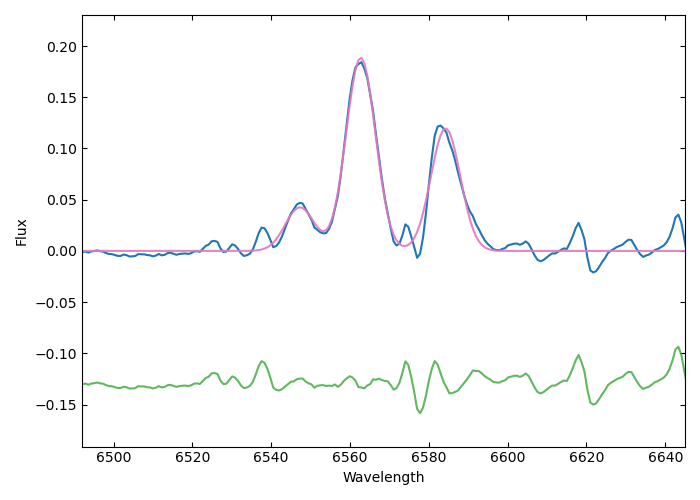

[]


In [22]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(s1_b[0]), s1_b[1]*np.exp(s1_b[0]), s1_b[2]) + \
                       gauss_cdf_scale(wav_res, np.exp(s2_b[0]), s2_b[1]*np.exp(s2_b[0]), s2_b[2]))

nl, nb = 3, 0
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['NII6548', 'Halpha', 'NII6584'],# 'Broad3_2', 'Broad3_2'],
           'line_wav':[6549.86, 6564.61, 6585.27],# 6564.61, 6564.61],
           'line_sigma':[4.0], 'wav_fit':[6542.0, 6595.0],
           'line_model':lm}

s3, e_s3 = line_fit(3, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=False, ytot=ysub, **kw_lpar)

### 3.1.3. Combining All Components

<IPython.core.display.Javascript object>


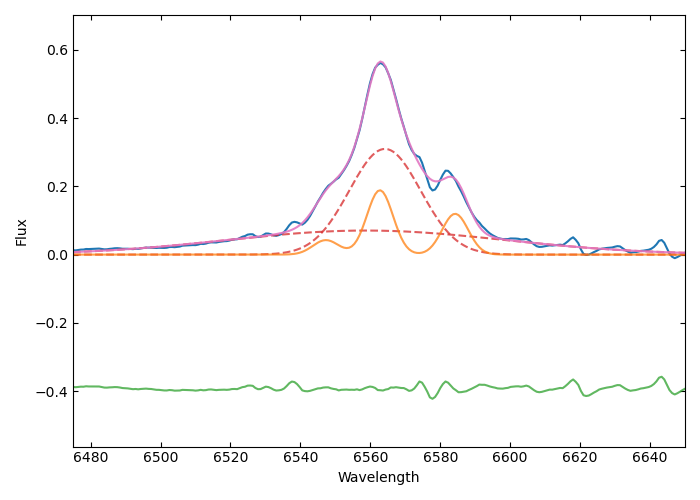

Total reduced chi-square: 13.38


In [23]:
# Combing all the components
npar, e_npar = s3, e_s3
bpar, e_bpar = [s1_b, s2_b], [e_s1_b, e_s2_b]
cpar = list(npar) + list(bpar[0]) + list(bpar[1])
e_cpar = list(e_npar) + list(e_bpar[0]) + list(e_bpar[1])
nl, nb, num = 5, 2, 3

lp = line_par(num, broad_component=True)
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = lp
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]    
y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
y_mod = lm(np.log(wav_res), *cpar) / wav_res
flxscl = np.sum(np.abs(y_loc)*x_bin)

# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-25.0, wav_fit[1]+25.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum, color='C0')
for i in np.arange(len(bpar)):
    y_plt = gauss_cdf_scale(np.log(wav_res), *bpar[i]) / wav_res
    ax.plot(wav_res, y_plt, color='C3', linestyle='--', alpha=0.75)
ax.plot(wav_res, multin_gauss_cdf_scale(np.log(wav_res), *npar, n=nl-nb, n_broad=0) / wav_res,
        color='C1', linestyle='-', alpha=0.75)
ax.plot(wav_res, fit_spectrum - y_mod - 0.7*np.abs(np.max(y_loc)), color='C2', alpha=0.75)
ax.plot(wav_res, y_mod, color='C6', alpha=0.9)
plt.tight_layout()
plt.savefig("fit0_line03.png", dpi=300)

# Calculating reduced chi-square
chisq = ((x_wav*y_loc - lm(np.log(x_wav), *cpar)) / (x_wav*np.sqrt(y_var)))**2.
dof = len(y_loc) - len(cpar)
rchisq = np.sum(chisq) / dof
print(f"Total reduced chi-square: {rchisq:.2f}")

In [24]:
# Writing files
line_names = ['NII6548', 'Halpha', 'NII6584', 'Broad3_1', 'Broad3_2']
for i in np.arange(nl):
    if (i < nl-nb):
        mu, e_mu = np.exp(cpar[2*i+1]), np.exp(cpar[2*i+1])*e_cpar[2*i+1]
        vsig, e_vsig = c*cpar[0], c*e_cpar[0]
        flux, e_flux = cpar[2*i+2], e_cpar[2*i+2]
        lsig = mu * vsig / c
        e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
        specR, e_specR = par[0]+par[1]*mu*(1+redshift), np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
        F1 = gauss_cdf_scale(np.log(wav_res), cpar[2*i+1], cpar[0], cpar[2*i+2]) / wav_res
        eqw = np.trapz(-F1/fit_continuum, x=wav_res)
        
        f = open('linefit_integrated.txt','a')
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}  ")
        f.write(f"{eqw:.2f}\n")
        f.close()
    else:
        i_b = i-(nl-nb)
        npn = 2*(nl-nb)
        mu, e_mu = np.exp(cpar[npn+3*i_b+1]), np.exp(cpar[npn+3*i_b+1])*e_cpar[npn+3*i_b+1]
        vsig, e_vsig = c*cpar[npn+3*i_b+2], c*e_cpar[npn+3*i_b+2]
        flux, e_flux = cpar[npn+3*i_b+3], e_cpar[npn+3*i_b+3]
        lsig = mu * vsig / c
        e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
        specR, e_specR = par[0]+par[1]*mu*(1+redshift), np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
        F1 = gauss_cdf_scale(np.log(wav_res), cpar[npn+3*i_b+1], cpar[npn+3*i_b+2], cpar[npn+3*i_b+3]) / wav_res
        
        g = open('linefit_integrated_broad.txt','a')
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flxscl:.2e}\n")
        g.close()
        
# Saving plot data
np.savez("plot_Ha.npz", wav=wav_res, data=fit_spectrum,
         narrow=multin_gauss_cdf_scale(np.log(wav_res), *npar, n=3, n_broad=0) / wav_res,
         broad1=gauss_cdf_scale(np.log(wav_res), *bpar[0]) / wav_res,
         broad2=gauss_cdf_scale(np.log(wav_res), *bpar[1]) / wav_res,
         mod=y_mod,
         resi=fit_spectrum - y_mod - 0.7*np.abs(np.max(y_loc)),
         xl=wav_fit[0]-25.0, xh=wav_fit[1]+25.0,
         yl=np.min(y_loc)-1.0*np.abs(np.max(y_loc)), yh=1.25*np.abs(np.max(y_loc)))

## 3.2. ${\rm [SII]\lambda\lambda6717,6731}$

### 3.2.1. Automatic

100%|██████████| 1000/1000 [00:02<00:00, 376.10it/s]

----- Narrow components -----
SII6717 mean: 6716.265 +/- 0.080 Angstrom
SII6717 sigma: 180.17 +/- 2.820 km/s
SII6717 sigma: 4.036 +/- 0.063 Angstrom
SII6717 R: 1228.02 +/- 45.39
SII6717 flux: 4.12e-01 +/- 6.21e-03
SII6717 equivalent width: -6.41 Angstrom
Total reduced chi-square: 1.36


SII6731 mean: 6730.861 +/- 0.107 Angstrom
SII6731 sigma: 180.17 +/- 2.820 km/s
SII6731 sigma: 4.045 +/- 0.063 Angstrom
SII6731 R: 1230.70 +/- 45.45
SII6731 flux: 3.51e-01 +/- 6.16e-03
SII6731 equivalent width: -5.47 Angstrom
Total reduced chi-square: 1.36




<IPython.core.display.Javascript object>


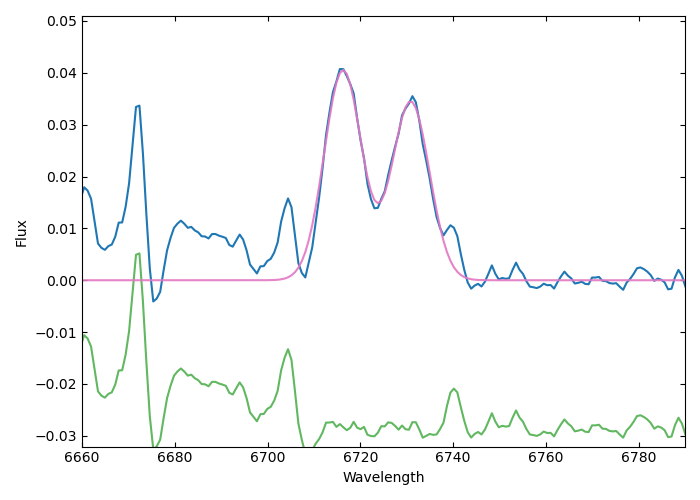

[]


[array([6.00987199e-04, 8.81228754e+00, 4.11862311e-01, 8.81445831e+00,
        3.51204676e-01]),
 array([9.40567589e-06, 1.19554013e-05, 6.20733633e-03, 1.59076646e-05,
        6.16288556e-03])]

In [25]:
line_fit(4, n_fit=1000, maxfev=2000, write=True, broad_component=False)

## 3.3. ${\rm [OII]\lambda\lambda3727,3729}$

### 3.3.1. Automatic

100%|██████████| 1000/1000 [00:01<00:00, 946.48it/s]

----- Narrow components -----
OII3727 mean: 3726.897 +/- 0.150 Angstrom
OII3727 sigma: 243.43 +/- 11.523 km/s
OII3727 sigma: 3.026 +/- 0.143 Angstrom
OII3727 R: 679.45 +/- 34.71
OII3727 flux: 6.58e-01 +/- 2.86e-02
OII3727 equivalent width: -5.16 Angstrom
Total reduced chi-square: 0.25




<IPython.core.display.Javascript object>


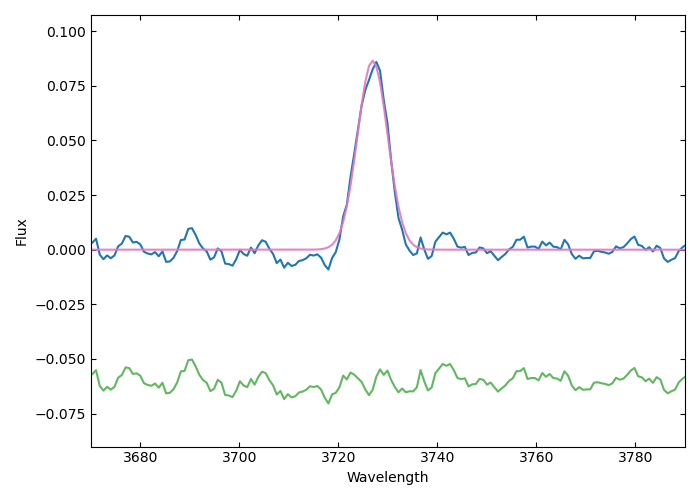

[]


[array([8.11999111e-04, 8.22333135e+00, 6.57792143e-01]),
 array([3.84354908e-05, 4.03650611e-05, 2.85879029e-02])]

In [26]:
line_fit(0, n_fit=1000, maxfev=2000, write=True, broad_component=False)

## 3.4. ${\rm H\beta}+{\rm [OIII]\lambda\lambda4959,5007}$

### 3.4.1. Automatic

100%|██████████| 100/100 [00:01<00:00, 53.03it/s]


----- Narrow components -----
Hbeta mean: 4861.173 +/- 0.051 Angstrom
Hbeta sigma: 478.74 +/- 4.144 km/s
Hbeta sigma: 7.763 +/- 0.067 Angstrom
Hbeta R: 887.60 +/- 38.37
Hbeta flux: 3.42e+00 +/- 2.11e-02
Hbeta equivalent width: -45.27 Angstrom
Total reduced chi-square: 57.71


OIII4959 mean: 4957.000 +/- 0.128 Angstrom
OIII4959 sigma: 478.74 +/- 4.144 km/s
OIII4959 sigma: 7.916 +/- 0.069 Angstrom
OIII4959 R: 905.18 +/- 38.70
OIII4959 flux: 7.00e-01 +/- 1.05e-02
OIII4959 equivalent width: -9.41 Angstrom
Total reduced chi-square: 57.71


OIII5007 mean: 5005.538 +/- 0.038 Angstrom
OIII5007 sigma: 478.74 +/- 4.144 km/s
OIII5007 sigma: 7.993 +/- 0.069 Angstrom
OIII5007 R: 914.09 +/- 38.87
OIII5007 flux: 2.60e+00 +/- 1.11e-02
OIII5007 equivalent width: -35.30 Angstrom
Total reduced chi-square: 57.71




<IPython.core.display.Javascript object>


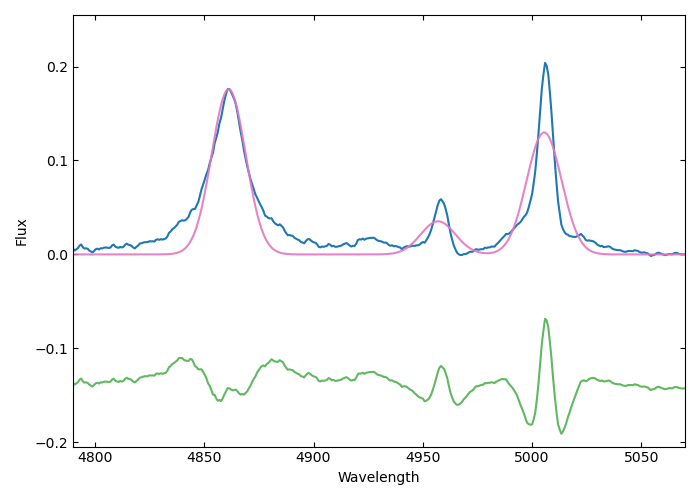

[]


[array([1.59690326e-03, 8.48903501e+00, 3.42475233e+00, 8.50855609e+00,
        7.00444853e-01, 8.51830008e+00, 2.60427380e+00]),
 array([1.38220942e-05, 1.04749313e-05, 2.10700839e-02, 2.57257930e-05,
        1.05194449e-02, 7.57574237e-06, 1.11280872e-02])]

In [27]:
line_fit(6, n_fit=100, maxfev=2000, write=False, broad_component=False)

### 3.4.2. Manual

100%|██████████| 100/100 [00:00<00:00, 789.19it/s]

----- Broad components -----
FeII_4923 mean: 4924.502 +/- 1.882 Angstrom
FeII_4923 sigma: 662.12 +/- 115.385 km/s
FeII_4923 sigma: 10.876 +/- 1.895 Angstrom
FeII_4923 R: 899.22 +/- 38.59
FeII_4923 flux: 4.67e-01 +/- 8.87e-02
FeII_4923 equivalent width: -6.24 Angstrom
Total reduced chi-square: 0.10




<IPython.core.display.Javascript object>


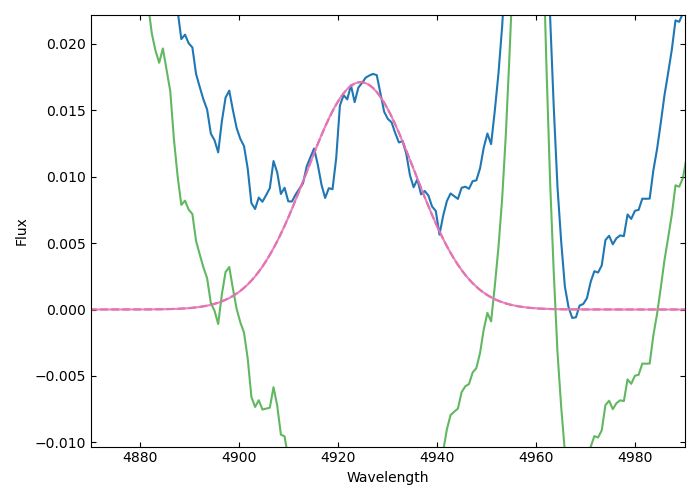

[8.50197851094614, 0.0022086111704273732, 0.46702342849414]


In [28]:
nl, nb = 1, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['FeII_4923'],
           'line_wav':[4927.0],
           'line_sigma':[5.0], 'wav_fit':[4920.0, 4940.0],
           'line_model':lm, 'mask_range':[[4820., 4885.]]}

f1, e_f1 = line_fit(6, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=False, xtot=wav_res, ytot=fit_spectrum, e2_ytot=fit_variance, **kw_lpar)

100%|██████████| 100/100 [00:00<00:00, 703.33it/s]

----- Broad components -----
Broad1_1 mean: 4861.072 +/- 0.733 Angstrom
Broad1_1 sigma: 1175.73 +/- 46.822 km/s
Broad1_1 sigma: 19.064 +/- 0.759 Angstrom
Broad1_1 R: 887.58 +/- 38.37
Broad1_1 flux: 3.09e+00 +/- 1.08e-01
Broad1_1 equivalent width: -40.83 Angstrom
Total reduced chi-square: 0.81




<IPython.core.display.Javascript object>


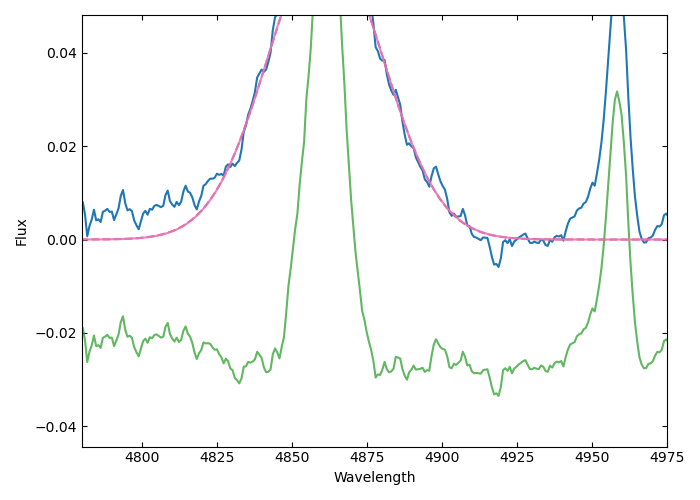

[8.489014282672525, 0.003921803990897139, 3.0893269670049857]


In [29]:
ysub = fit_spectrum - gauss_cdf_scale(wav_res, np.exp(f1[0]), f1[1]*np.exp(f1[0]), f1[2])

nl, nb = 1, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['Broad1_1'],
           'line_wav':[4862.68],
           'line_sigma':[20.0], 'wav_fit':[4830.0, 4925.0],
           'line_model':lm, 'mask_range':[[4840., 4880.]]}

t1, e_t1 = line_fit(6, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=True, xtot=wav_res, ytot=ysub, e2_ytot=fit_variance, **kw_lpar)

100%|██████████| 100/100 [00:00<00:00, 549.11it/s]

----- Broad components -----
Fe2? mean: 4799.065 +/- 2.788 Angstrom
Fe2? sigma: 1097.00 +/- 144.934 km/s
Fe2? sigma: 17.561 +/- 2.320 Angstrom
Fe2? R: 876.20 +/- 38.15
Fe2? flux: 2.95e-01 +/- 3.40e-02
Fe2? equivalent width: -3.86 Angstrom
Total reduced chi-square: 0.31




<IPython.core.display.Javascript object>


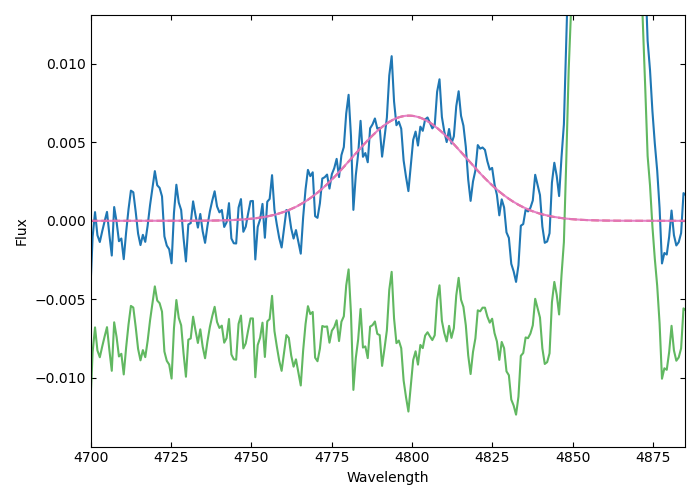

[8.476176442026452, 0.003659204509015648, 0.2950709797665843]


In [30]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[0]), f1[1]*np.exp(f1[0]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(t1[0]), t1[1]*np.exp(t1[0]), t1[2]))

nl, nb = 1, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['Fe2?'],
           'line_wav':[4800.0],
           'line_sigma':[15.0], 'wav_fit':[4750.0, 4835.0],
           'line_model':lm, 'mask_range':[[4840., 4880.]]}

f2, e_f2 = line_fit(6, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=True, xtot=wav_res, ytot=ysub, e2_ytot=fit_variance, **kw_lpar)

100%|██████████| 100/100 [00:00<00:00, 121.26it/s]

----- Narrow components -----
Hbeta mean: 4862.747 +/- 0.700 Angstrom
Hbeta sigma: 207.27 +/- 32.046 km/s
Hbeta sigma: 3.362 +/- 0.520 Angstrom
Hbeta R: 887.89 +/- 38.37
Hbeta flux: 2.54e-01 +/- 1.62e-01
Hbeta equivalent width: -3.36 Angstrom
Total reduced chi-square: 0.48


----- Broad components -----
Broad1_1 mean: 4860.617 +/- 0.940 Angstrom
Broad1_1 sigma: 389.90 +/- 24.654 km/s
Broad1_1 sigma: 6.322 +/- 0.400 Angstrom
Broad1_1 R: 887.50 +/- 38.36
Broad1_1 flux: 1.33e+00 +/- 1.63e-01
Broad1_1 equivalent width: -17.63 Angstrom
Total reduced chi-square: 0.48




<IPython.core.display.Javascript object>


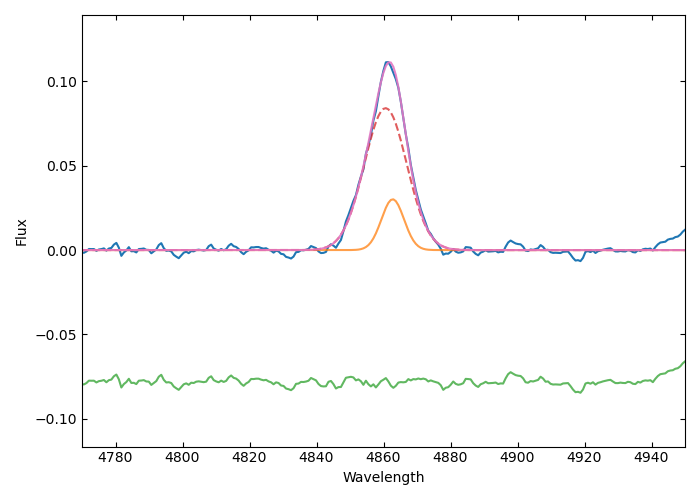

[8.488920594531258, 0.0013005657274339066, 1.3338540735003712]


In [31]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[0]), f1[1]*np.exp(f1[0]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(t1[0]), t1[1]*np.exp(t1[0]), t1[2]) +
                       gauss_cdf_scale(wav_res, np.exp(f2[0]), f2[1]*np.exp(f2[0]), f2[2]))

nl, nb = 2, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['Hbeta', 'Broad1_1'],
           'line_wav':[4862.68, 4862.68],
           'line_sigma':[3.0, 6.0], 'wav_fit':[4820.0, 4900.0],
           'line_model':lm, 'mask_range':[[4855., 4870.]]}

t2, e_t2 = line_fit(6, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=False, xtot=wav_res, ytot=ysub, e2_ytot=fit_variance, **kw_lpar)
t2_b, e_t2_b = t2[2*(nl-nb)+1:], e_t2[2*(nl-nb)+1:]

100%|██████████| 100/100 [00:00<00:00, 187.90it/s]

----- Narrow components -----
OIII4959 mean: 4958.039 +/- 0.076 Angstrom
OIII4959 sigma: 210.89 +/- 5.339 km/s
OIII4959 sigma: 3.488 +/- 0.088 Angstrom
OIII4959 R: 905.37 +/- 38.70
OIII4959 flux: 4.98e-01 +/- 9.18e-03
OIII4959 equivalent width: -6.69 Angstrom
Total reduced chi-square: 1.34


----- Broad components -----
Broad2_1 mean: 5008.672 +/- 1.030 Angstrom
Broad2_1 sigma: 1048.77 +/- 67.739 km/s
Broad2_1 sigma: 17.522 +/- 1.132 Angstrom
Broad2_1 R: 914.66 +/- 38.88
Broad2_1 flux: 1.05e+00 +/- 1.23e-01
Broad2_1 equivalent width: -14.20 Angstrom
Total reduced chi-square: 1.34




<IPython.core.display.Javascript object>


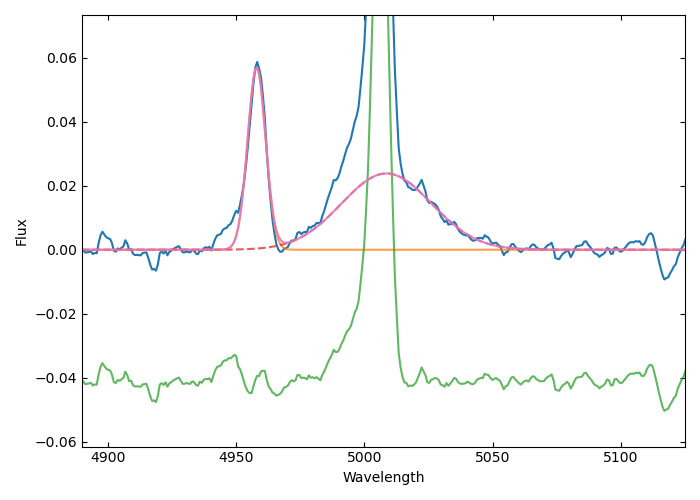

[8.51892602100467, 0.003498311492618923, 1.0466513817748728]


In [32]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[0]), f1[1]*np.exp(f1[0]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(f2[0]), f2[1]*np.exp(f2[0]), f2[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t1[0]), t1[1]*np.exp(t1[0]), t1[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t2_b[0]), t2_b[1]*np.exp(t2_b[0]), t2_b[2]))

nl, nb = 2, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['OIII4959', 'Broad2_1'],
           'line_wav':[4960.295, 5008.240],
           'line_sigma':[4.0, 15.0], 'wav_fit':[4940.0, 5075.0],
           'line_model':lm, 'mask_range':[[4979., 5027.]]}

r1, e_r1 = line_fit(6, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=True, xtot=wav_res, ytot=ysub, e2_ytot=fit_variance, **kw_lpar)
r1_b, e_r1_b = r1[2*(nl-nb)+1:], e_r1[2*(nl-nb)+1:]

100%|██████████| 100/100 [00:01<00:00, 58.33it/s]

----- Narrow components -----
OIII4959 mean: 4958.091 +/- 0.069 Angstrom
OIII4959 sigma: 196.34 +/- 2.563 km/s
OIII4959 sigma: 3.247 +/- 0.042 Angstrom
OIII4959 R: 905.38 +/- 38.70
OIII4959 flux: 4.79e-01 +/- 8.30e-03
OIII4959 equivalent width: -6.44 Angstrom
Total reduced chi-square: 1.19


OIII5007 mean: 5005.798 +/- 0.076 Angstrom
OIII5007 sigma: 196.34 +/- 2.563 km/s
OIII5007 sigma: 3.278 +/- 0.043 Angstrom
OIII5007 R: 914.14 +/- 38.87
OIII5007 flux: 1.62e+00 +/- 6.14e-02
OIII5007 equivalent width: -21.92 Angstrom
Total reduced chi-square: 1.19


----- Broad components -----
Broad2_2 mean: 4994.983 +/- 0.642 Angstrom
Broad2_2 sigma: 341.65 +/- 29.539 km/s
Broad2_2 sigma: 5.692 +/- 0.492 Angstrom
Broad2_2 R: 912.15 +/- 38.83
Broad2_2 flux: 2.37e-01 +/- 2.33e-02
Broad2_2 equivalent width: -3.20 Angstrom
Total reduced chi-square: 1.19




<IPython.core.display.Javascript object>


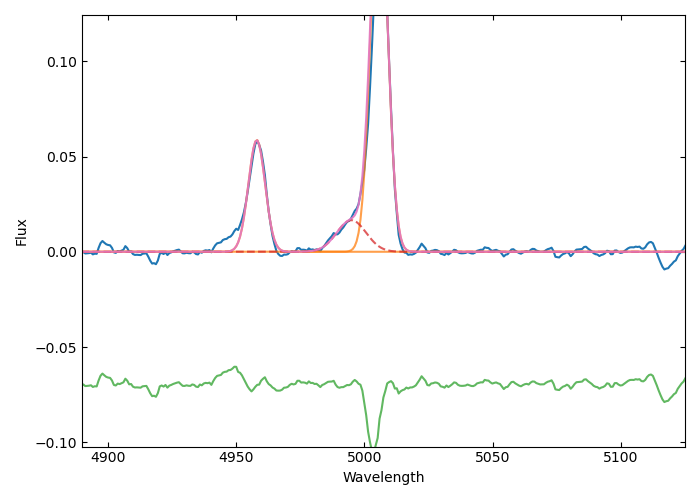

[8.5161893436604, 0.0011396078725232918, 0.23677805917431943]


In [33]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[0]), f1[1]*np.exp(f1[0]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(f2[0]), f2[1]*np.exp(f2[0]), f2[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t1[0]), t1[1]*np.exp(t1[0]), t1[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t2_b[0]), t2_b[1]*np.exp(t2_b[0]), t2_b[2]) +
                       gauss_cdf_scale(wav_res, np.exp(r1_b[0]), r1_b[1]*np.exp(r1_b[0]), r1_b[2]))
                       
nl, nb = 3, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['OIII4959', 'OIII5007', 'Broad2_2', 'Broad2_3'],
           'line_wav':[4960.295, 5008.240, 4995.0, 4948.0],
           'line_sigma':[3.5, 5.0, 5.0], 'wav_fit':[4940.0, 5075.0],
           'line_model':lm, 'mask_range':[[5000., 5010.]]}

r2, e_r2 = line_fit(6, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=True, ytot=ysub, **kw_lpar)
r2_b, e_r2_b = r2[2*(nl-nb)+1:], e_r2[2*(nl-nb)+1:]
r3_b = np.array([np.log(np.exp(r2_b[0])-(5008.240 - 4960.295)), r2_b[1], r2_b[2] / 3.])
e_r3_b = np.array([e_r2[2*(nl-nb)+1], e_r2[2*(nl-nb)+2], e_r2[2*(nl-nb)+3] / 3.])

100%|██████████| 1000/1000 [00:07<00:00, 127.93it/s]

----- Narrow components -----
Hbeta mean: 4862.825 +/- 0.182 Angstrom
Hbeta sigma: 192.18 +/- 1.348 km/s
Hbeta sigma: 3.117 +/- 0.022 Angstrom
Hbeta R: 887.90 +/- 38.37
Hbeta flux: 2.36e-01 +/- 9.10e-03
Hbeta equivalent width: -3.12 Angstrom
Total reduced chi-square: 0.69


OIII4959 mean: 4958.256 +/- 0.069 Angstrom
OIII4959 sigma: 192.18 +/- 1.348 km/s
OIII4959 sigma: 3.178 +/- 0.022 Angstrom
OIII4959 R: 905.41 +/- 38.71
OIII4959 flux: 4.62e-01 +/- 7.28e-03
OIII4959 equivalent width: -6.21 Angstrom
Total reduced chi-square: 0.69


OIII5007 mean: 5006.233 +/- 0.023 Angstrom
OIII5007 sigma: 192.18 +/- 1.348 km/s
OIII5007 sigma: 3.209 +/- 0.023 Angstrom
OIII5007 R: 914.22 +/- 38.87
OIII5007 flux: 1.41e+00 +/- 8.89e-03
OIII5007 equivalent width: -19.14 Angstrom
Total reduced chi-square: 0.69




<IPython.core.display.Javascript object>


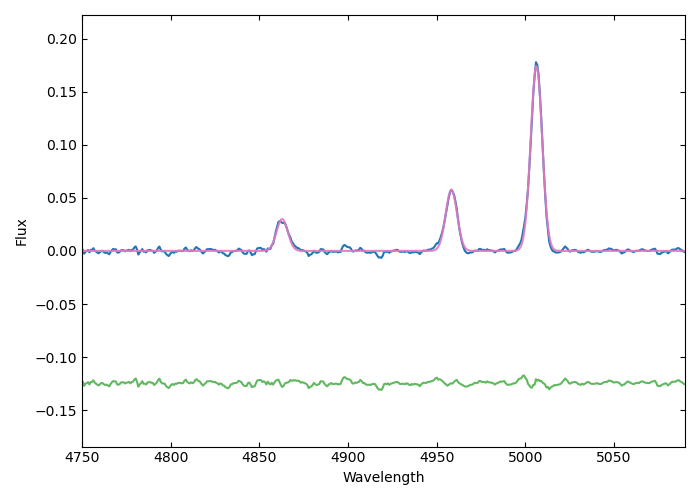

[]


In [34]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[0]), f1[1]*np.exp(f1[0]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(f2[0]), f2[1]*np.exp(f2[0]), f2[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t1[0]), t1[1]*np.exp(t1[0]), t1[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t2_b[0]), t2_b[1]*np.exp(t2_b[0]), t2_b[2]) +
                       gauss_cdf_scale(wav_res, np.exp(r1_b[0]), r1_b[1]*np.exp(r1_b[0]), r1_b[2]) +
                       gauss_cdf_scale(wav_res, np.exp(r2_b[0]), r2_b[1]*np.exp(r2_b[0]), r2_b[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(r3_b[0]), r3_b[1]*np.exp(r3_b[0]), r3_b[2]))

nl, nb = 3, 0
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['Hbeta', 'OIII4959', 'OIII5007'],
           'line_wav':[4862.68, 4960.295, 5008.240],
           'line_sigma':[3.0], 'wav_fit':[4800.0, 5040.0],
           'line_model':lm, 'mask_range':[[5000., 5012.]]}

ho, e_ho = line_fit(6, n_fit=1000, maxfev=2000, write=False, broad_component=False,
                    mode='manual', mask=False, ytot=ysub, **kw_lpar)

### 3.4.3. Combining All Components

<IPython.core.display.Javascript object>


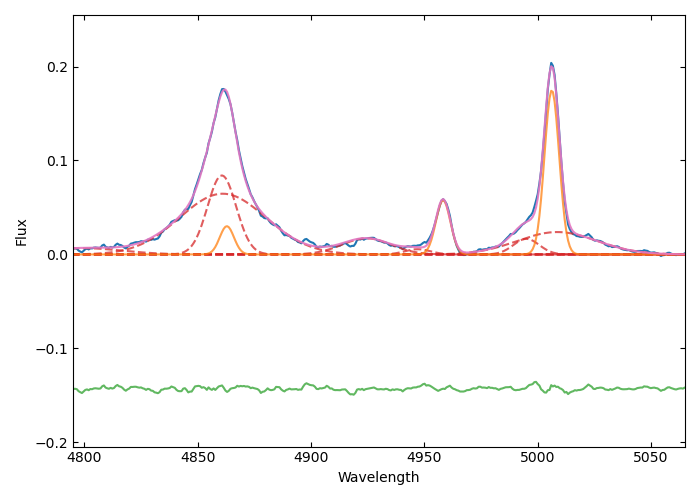

Total reduced chi-square: 0.78


In [35]:
# Combing all the components
npar, e_npar = ho, e_ho
bpar, e_bpar = [f1, f2, t1, t2_b, r1_b, r2_b, r3_b], [e_f1, e_f2, e_t1, e_t2_b, e_r1_b, e_r2_b, e_r3_b]
cpar = list(npar) + list(bpar[0]) + list(bpar[1]) + list(bpar[2]) + list(bpar[3]) + \
       list(bpar[4]) + list(bpar[5]) + list(bpar[6])
e_cpar = list(e_npar) + list(e_bpar[0]) + list(e_bpar[1]) + list(e_bpar[2]) + list(e_bpar[3]) + \
         list(e_bpar[4]) + list(e_bpar[5]) + list(e_bpar[6])
nl, nb, num = 10, 7, 6

lp = line_par(num, broad_component=True)
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = lp
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]    
y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
y_mod = lm(np.log(wav_res), *cpar) / wav_res
flxscl = np.sum(np.abs(y_loc)*x_bin)

# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-25.0, wav_fit[1]+25.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum, color='C0')
for i in np.arange(len(bpar)):
    y_plt = gauss_cdf_scale(np.log(wav_res), *bpar[i]) / wav_res
    ax.plot(wav_res, y_plt, color='C3', linestyle='--', alpha=0.75)
ax.plot(wav_res, multin_gauss_cdf_scale(np.log(wav_res), *npar, n=nl-nb, n_broad=0) / wav_res,
        color='C1', linestyle='-', alpha=0.75)
ax.plot(wav_res, fit_spectrum - y_mod - 0.7*np.abs(np.max(y_loc)), color='C2', alpha=0.75)
ax.plot(wav_res, y_mod, color='C6', alpha=0.9)
plt.tight_layout()
plt.savefig("fit0_line06.png", dpi=300)

# Calculating reduced chi-square
chisq = ((x_wav*y_loc - lm(np.log(x_wav), *cpar)) / (x_wav*np.sqrt(y_var)))**2.
dof = len(y_loc) - len(cpar)
rchisq = np.sum(chisq) / dof
print(f"Total reduced chi-square: {rchisq:.2f}")

In [36]:
# Writing files
line_names = ['Hbeta', 'OIII4959', 'OIII5007', 'Broad6_1', 'Broad6_2', 'Broad6_3', 'Broad6_4',
              'Broad6_5', 'Broad6_6', 'Broad6_7']
for i in np.arange(nl):
    if (i < nl-nb):
        mu, e_mu = np.exp(cpar[2*i+1]), np.exp(cpar[2*i+1])*e_cpar[2*i+1]
        vsig, e_vsig = c*cpar[0], c*e_cpar[0]
        flux, e_flux = cpar[2*i+2], e_cpar[2*i+2]
        lsig = mu * vsig / c
        e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
        specR, e_specR = par[0]+par[1]*mu*(1+redshift), np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
        F1 = gauss_cdf_scale(np.log(wav_res), cpar[2*i+1], cpar[0], cpar[2*i+2]) / wav_res
        eqw = np.trapz(-F1/fit_continuum, x=wav_res)
        
        f = open('linefit_integrated.txt','a')
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}  ")
        f.write(f"{eqw:.2f}\n")
        f.close()
    else:
        i_b = i-(nl-nb)
        npn = 2*(nl-nb)
        mu, e_mu = np.exp(cpar[npn+3*i_b+1]), np.exp(cpar[npn+3*i_b+1])*e_cpar[npn+3*i_b+1]
        vsig, e_vsig = c*cpar[npn+3*i_b+2], c*e_cpar[npn+3*i_b+2]
        flux, e_flux = cpar[npn+3*i_b+3], e_cpar[npn+3*i_b+3]
        lsig = mu * vsig / c
        e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
        specR, e_specR = par[0]+par[1]*mu*(1+redshift), np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
        F1 = gauss_cdf_scale(np.log(wav_res), cpar[npn+3*i_b+1], cpar[npn+3*i_b+2], cpar[npn+3*i_b+3]) / wav_res
        
        g = open('linefit_integrated_broad.txt','a')
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flxscl:.2e}\n")
        g.close()

In [37]:
# Calculating Ha/Hb ratio
EWc = 2.5
F_Ha = ((27.07+EWc)/27.07) * 1.76e+00
F_Hb = ((3.12+EWc)/3.12) * 2.36e-01
print(1.76e+00 / 2.36e-01)
print(F_Ha/F_Hb)

7.457627118644068
4.52253578611082


# 4. Additional Tasks for Broad Components

## 4.1. Creating a New Image with Gaussian Profile

In [38]:
from astropy.modeling.models import Gaussian2D
fwhm = 0.71    # arcsec (from acquisition images)
pixel_scale = 0.1    # arcsec/pix
x_sigma = (fwhm/pixel_scale) / (2.0*np.sqrt(2.0*np.log(2.0)))
y_sigma = (fwhm/pixel_scale) / (2.0*np.sqrt(2.0*np.log(2.0)))
print(x_sigma, y_sigma)
g2d = Gaussian2D(amplitude = 1, x_mean = yInd, y_mean = xInd, x_stddev = x_sigma, y_stddev = y_sigma)
img_g2d = g2d(*np.mgrid[0:d_sci.shape[1], 0:d_sci.shape[2]])

3.0150923910224674 3.0150923910224674


<IPython.core.display.Javascript object>


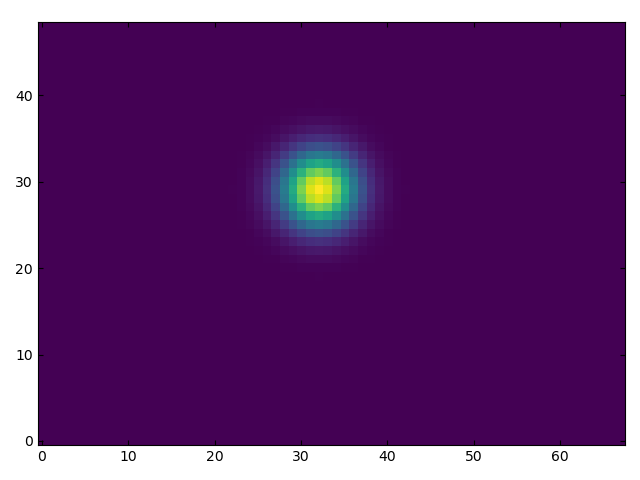

In [39]:
fig, ax = plt.subplots()
ax.imshow(img_g2d, origin = 'lower')
plt.tight_layout()

fits.writeto("g2d.fits", img_g2d, overwrite=True)

## 4.2. Checking for Spectra in an Arbitrary Bin

### 4.2.1. Setting an Arbitrary Bin

In [40]:
nbin = 44    # arbitrary bin

print(f"Bin {nbin:d}")

fit_spectrum = dat[:, nbin]
fit_variance = var[:, nbin]
fit_continuum = cont[:, nbin]

Bin 44


In [41]:
indices = np.argwhere(data_vbin == nbin)
print("The (x,y) indices of the bin")
print(indices)

The (x,y) indices of the bin
[[29 28]]


In [42]:
npix = indices.shape[0]
print(f"Number of pixels in the bin: {npix:d}")

Number of pixels in the bin: 1


### 4.2.2. Creating an Image of Initial Guess for the Broad Component Factors

In [43]:
print("Gaussian factors of this bin:")
img_g2d[indices[:, 0], indices[:, 1]]

Gaussian factors of this bin:


array([0.41477781])

In [44]:
fac = np.sum(img_g2d[indices[:, 0], indices[:, 1]]) / npix
if (mode == "subcircular"):
    fac /= (np.sum(img_g2d*msk))
print(f"Mean Gaussian factor of broad components: {fac:.3e}")

Mean Gaussian factor of broad components: 1.250e-02


<IPython.core.display.Javascript object>


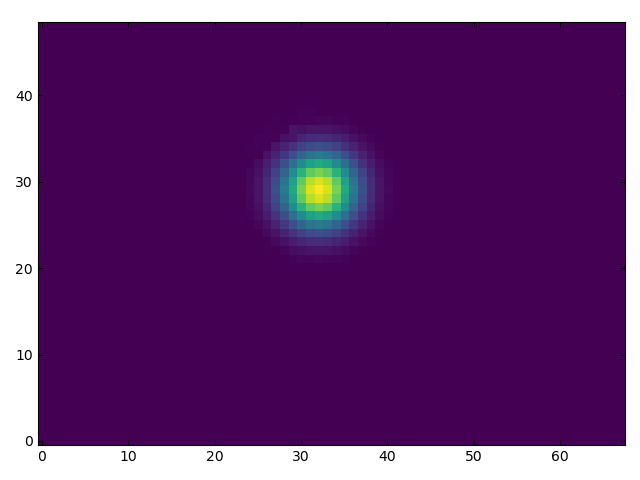

In [45]:
gfac = np.zeros_like(img_g2d)
for b in np.unique(data_vbin):
    binwhere = np.argwhere(data_vbin == b)
    if (b == -99):
        fc = 0.0
    else:
        fc = np.sum(img_g2d[binwhere[:, 0], binwhere[:, 1]])
#         fc = img_g2d[binwhere[:, 0], binwhere[:, 1]].max()
    gfac[data_vbin == b] = fc / binwhere.shape[0]
    
fig, ax = plt.subplots()
ax.imshow(gfac, origin = 'lower', vmin=0.01, vmax=1.0)
plt.tight_layout()
fits.writeto("gfac.fits", gfac, overwrite=True)

### 4.2.3. Plotting the Spectra for Visual Check

<IPython.core.display.Javascript object>


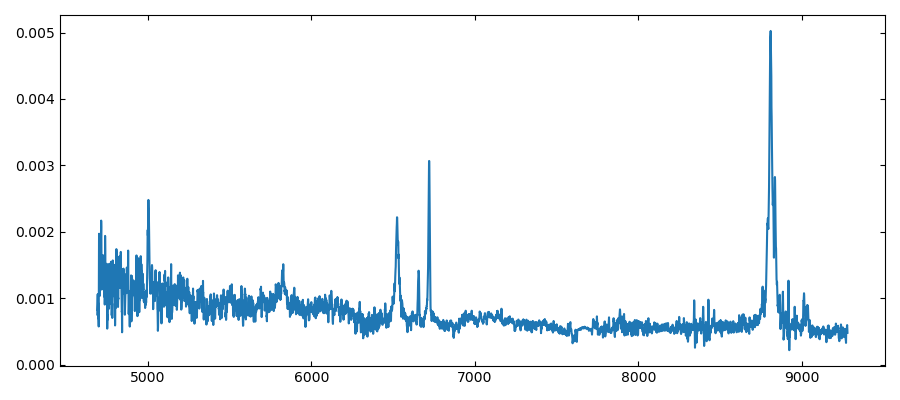

In [46]:
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

fig, ax = plt.subplots(figsize=(9,4))
# ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
# ax.plot(wav_res, fit_spectrum)
# ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar_b1[0], mpar_b1[1], fac*mpar_b1[2]))
# ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar_b2[0], mpar_b2[1], fac*mpar_b2[2]))
ax.plot(wav_obs, binned_spectrum[:, nbin] / indices.shape[0])
plt.tight_layout()

<IPython.core.display.Javascript object>


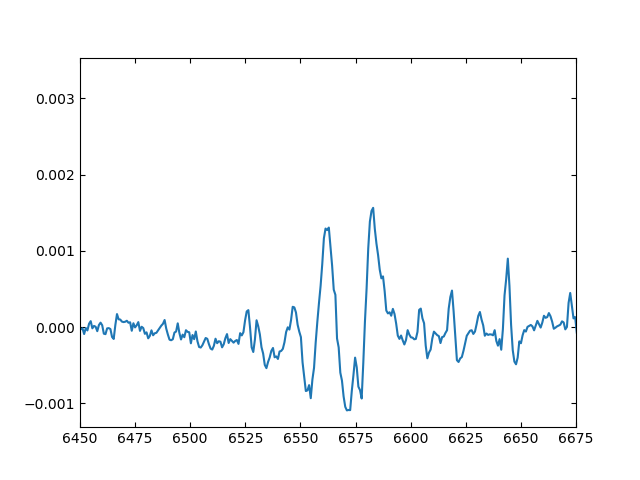

In [47]:
npar, e_npar = s3, e_s3
bpar, e_bpar = [s1_b, s2_b], [e_s1_b, e_s2_b]
cpar = list(npar) + list(bpar[0]) + list(bpar[1])
e_cpar = list(e_npar) + list(e_bpar[0]) + list(e_bpar[1])
nl, nb, num = 5, 2, 3

broad_plt = 0
for i in np.arange(nb):
    mpar_b = bpar[i]
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - fac*broad_plt)

### 4.2.4. Line Fitting with Fixing Broad Components

0.01249614276262053 ---> 0.00887509502473323
0.000243691624675339


----- Narrow components -----
NII6548 mean: 6547.374 +/- 0.507 Angstrom
NII6548 sigma: 152.72 +/- 6.635 km/s
NII6548 sigma: 3.335 +/- 0.145 Angstrom
NII6548 R: 1197.03 +/- 44.71
NII6548 flux: 5.41e-03 +/- 7.60e-04


Halpha mean: 6562.292 +/- 0.118 Angstrom
Halpha sigma: 152.72 +/- 6.635 km/s
Halpha sigma: 3.343 +/- 0.145 Angstrom
Halpha R: 1199.76 +/- 44.77
Halpha flux: 2.31e-02 +/- 1.56e-03


NII6584 mean: 6583.442 +/- 0.187 Angstrom
NII6584 sigma: 152.72 +/- 6.635 km/s
NII6584 sigma: 3.354 +/- 0.146 Angstrom
NII6584 R: 1203.64 +/- 44.86
NII6584 flux: 1.49e-02 +/- 8.41e-04


----- Broad components -----
Broad3_1 mean: 6558.926 +/- 0.000 Angstrom
Broad3_1 sigma: 1816.33 +/- 0.000 km/s
Broad3_1 sigma: 39.738 +/- 0.000 Angstrom
Broad3_1 R: 1199.15 +/- 44.76
Broad3_1 flux: 6.24e-02 +/- 1.71e-03


Broad3_2 mean: 6564.194 +/- 0.000 Angstrom
Broad3_2 sigma: 465.63 +/- 0.000 km/s
Broad3_2 sigma: 10.195 +/- 0.000 Angstrom
Broa

<IPython.core.display.Javascript object>


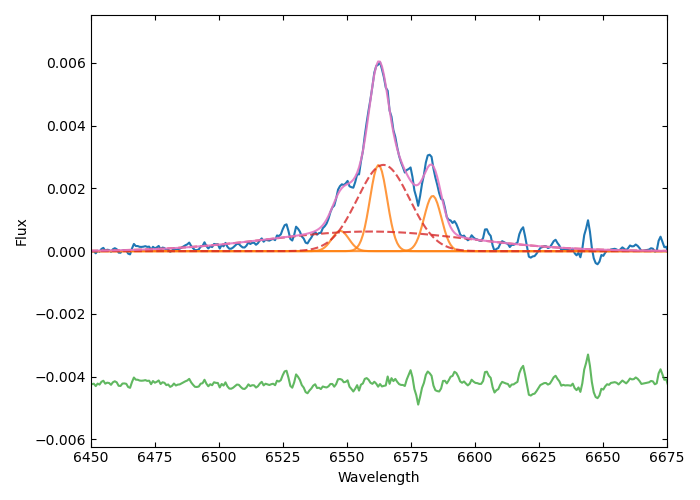

In [48]:
# Line fitting: Monte Carlo simulation of curve_fit (H alpha)
bpar, e_bpar = [s1_b, s2_b], [e_s1_b, e_s2_b]

line_numbers = 3
nlines, nbroad = 5, 2
line_names = ['NII6548', 'Halpha', 'NII6584', 'Broad3_1', 'Broad3_2']
line_wav = [6549.86, 6564.61, 6585.27]
line_sigma = [3.0]
wav_fit = [6500.0, 6625.0]
line_model = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nlines, n_broad=nbroad)


spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
y_dat = y_loc
flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
y_fit = x_wav * y_dat

broad_fit = 0
for i in np.arange(len(bpar)):
    mpar_b = bpar[i]
    broad_fit += gauss_cdf_scale(x_fit, *mpar_b)

    
# Model fitting
def line_model2(x, *pars):
    narrow_comp = 0
    for i in np.arange(nlines-nbroad):
        narrow_comp += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
    broad_comp = 10.**(pars[2*(nlines-nbroad)+1]) * broad_fit
    return narrow_comp + broad_comp
    
param = [line_sigma[0] / line_wav[0]]
for j in np.arange(nlines-nbroad):
    param += [np.log(line_wav[j]), flx_scale0 / nlines]
param += [np.log10(fac)]

popt, pcov = curve_fit(line_model2, x_fit, y_fit, param)
perr = np.sqrt(np.diag(pcov))
mpar, e_mpar = popt, perr


# Arranging parameters
ffac = 10.**(mpar[-1])
print(fac, "--->", ffac)#, "--->", ffac*ind_fac)
mpar = list(mpar[:2*(nlines-nbroad)+1])
for i in np.arange(len(bpar)):
    mpar_b = bpar[i]
    mpar += [mpar_b[0], mpar_b[1], ffac*mpar_b[2]]

e_ffac = ffac * np.log(10.0) * e_mpar[-1]
print(e_ffac)
e_mpar = list(e_mpar[:2*(nlines-nbroad)+1])
for i in np.arange(len(bpar)):
    mpar_b = bpar[i]
    e_mpar += [0.0, 0.0, e_ffac*mpar_b[2]]
print("\n")
    
    
# Printing the results
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    elif (nlines == nbroad):
        mu, e_mu = np.exp(mpar[3*i]), np.exp(mpar[3*i])*e_mpar[3*i]
        vsig, e_vsig = c*mpar[3*i+1], c*e_mpar[3*i+1]
        flux, e_flux = mpar[3*i+2], e_mpar[3*i+2]        
    else:
        i_b = i-(nlines-nbroad)
        npn = 2*(nlines-nbroad)
        mu, e_mu = np.exp(mpar[npn+3*i_b+1]), np.exp(mpar[npn+3*i_b+1])*e_mpar[npn+3*i_b+1]
        vsig, e_vsig = c*mpar[npn+3*i_b+2], c*e_mpar[npn+3*i_b+2]
        flux, e_flux = mpar[npn+3*i_b+3], e_mpar[npn+3*i_b+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")
    print("\n")


# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum, color='C0')
for i in np.arange(nlines-nbroad+len(bpar)):
    if (i < nlines-nbroad):
        y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        lc, ls = 'C1', '-'
    elif (nlines == nbroad):
        y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[3*i]), mpar[3*i+1]*np.exp(mpar[3*i]), mpar[3*i+2])
        lc, ls = 'C3', '--'
    else:
        i_b = i-(nlines-nbroad)
        npn = 2*(nlines-nbroad)
        y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[npn+3*i_b+1]),
                                mpar[npn+3*i_b+2]*np.exp(mpar[npn+3*i_b+1]), mpar[npn+3*i_b+3])
        lc, ls = 'C3', '--'
    ax.plot(wav_res, y_plt, color=lc, linestyle=ls, alpha=0.8)
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)),
        color='C2', alpha=0.75)
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res, color='C6', alpha=0.9)    
plt.tight_layout()

### 4.2.5. Check for Broad-Component-Subtracted Spectra

* ${\rm H\alpha+[NII]}\lambda\lambda6548,6584$

<IPython.core.display.Javascript object>


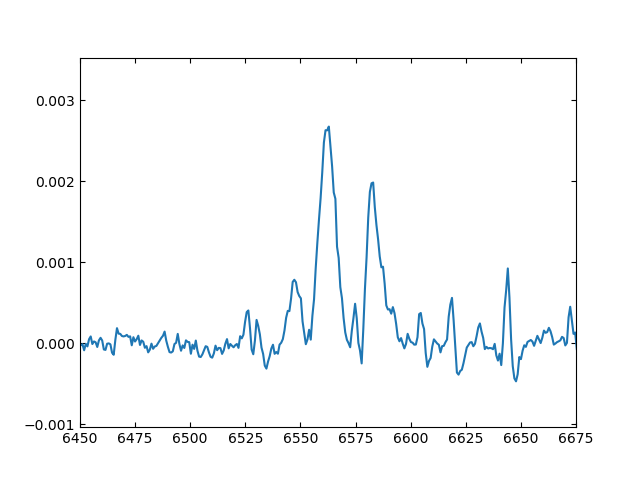

In [49]:
bpar, e_bpar = [s1_b, s2_b], [e_s1_b, e_s2_b]
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

broad_plt = 0
for i in np.arange(len(bpar)):
    mpar_b = bpar[i]
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - ffac*broad_plt)

* ${\rm H\beta}+{\rm [OIII]\lambda\lambda4959,5007}$

<IPython.core.display.Javascript object>


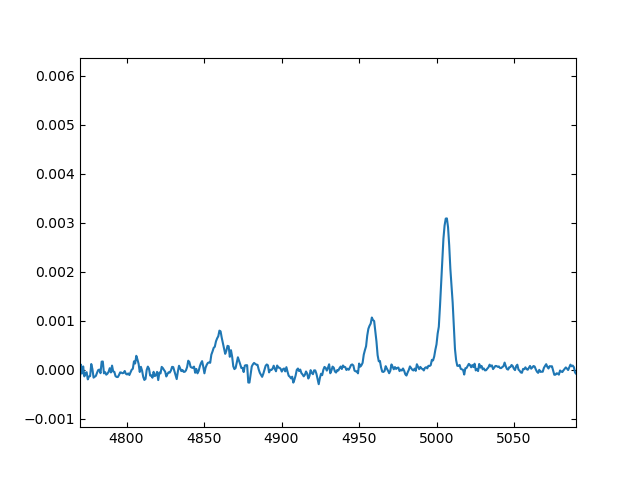

In [50]:
bpar, e_bpar = [f1, f2, t1, t2_b, r1_b, r2_b, r3_b], [e_f1, e_f2, e_t1, e_t2_b, e_r1_b, e_r2_b, e_r3_b]
line_numbers = 6
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

broad_plt = 0
for i in np.arange(len(bpar)):
    mpar_b = bpar[i]
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - ffac*broad_plt)

## 4.3. Creating the broad component factor map

* ${\rm H\alpha+[NII]}\lambda\lambda6548,6584$

In [51]:
bpar, e_bpar = [s1_b, s2_b], [e_s1_b, e_s2_b]

line_numbers = 3
nlines, nbroad = 5, 2
line_names = ['NII6548', 'Halpha', 'NII6584', 'Broad3_1', 'Broad3_2']
line_wav = [6549.86, 6564.61, 6585.27]
line_sigma = [3.0]
wav_fit = [6500.0, 6625.0]
line_model = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nlines, n_broad=nbroad)

bfac = np.zeros(binned_spectrum.shape[1])
e_bfac = np.zeros(binned_spectrum.shape[1])
nmax_bin = data_vbin[yInd, xInd]
bfac[nmax_bin], e_bfac[nmax_bin] = 1.0, 0.0
print(f"Maximum - Bin {nmax_bin:d} : {bfac[0]:.3f} +/- {e_bfac[0]:.3f}")

for ibin in np.arange(binned_spectrum.shape[1]):
# ibin = 0
    fit_spectrum = dat[:, ibin]
    fit_variance = var[:, ibin]
    indices = np.argwhere(data_vbin == ibin)
    npix = indices.shape[0]
    fac = np.sum(img_g2d[indices[:, 0], indices[:, 1]]) / npix
    if (mode == "subcircular"):
        fac /= (np.sum(img_g2d*msk))


    spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
               np.abs(wav_res-wav_fit[1]).argmin()]
    x_bin = wav_res[1] - wav_res[0]
    x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
    x_fit = np.log(x_wav)

    y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
    y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
    y_dat = y_loc
    flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
    y_fit = x_wav * y_dat


    broad_fit = 0
    for i in np.arange(len(bpar)):
        mpar_b = bpar[i]
        broad_fit += gauss_cdf_scale(x_fit, *mpar_b)

    # Model fitting
    def line_model2(x, *pars):
        narrow_comp = 0
        for i in np.arange(nlines-nbroad):
            narrow_comp += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
        broad_comp = 10.**(pars[2*(nlines-nbroad)+1]) * broad_fit
        return narrow_comp + broad_comp

    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines-nbroad):
        param += [np.log(line_wav[j]), flx_scale0 / nlines]
    param += [np.log10(fac)]

    try:
        popt, pcov = curve_fit(line_model2, x_fit, y_fit, param)
        perr = np.sqrt(np.diag(pcov))

        bfac[ibin] = 10.**(np.maximum(-7.0, popt[-1]))
        e_bfac[ibin] = bfac[ibin] * np.log(10.0) * perr[-1]

    except RuntimeError:
        bfac[ibin] = np.maximum(0.0, param[-1])#*indices.shape[0]
        e_bfac[ibin] = 0.0

    print(f"Bin {ibin:d} : {bfac[ibin]:.3e} +/- {e_bfac[ibin]:.3e}")

Maximum - Bin 0 : 1.000 +/- 0.000
Bin 0 : 3.771e-02 +/- 4.467e-04
Bin 1 : 3.435e-02 +/- 5.694e-04
Bin 2 : 3.322e-02 +/- 2.984e-04
Bin 3 : 3.347e-02 +/- 4.030e-04
Bin 4 : 2.560e-02 +/- 2.673e-04
Bin 5 : 2.820e-02 +/- 3.365e-04
Bin 6 : 2.260e-02 +/- 2.717e-04
Bin 7 : 1.783e-02 +/- 2.434e-04
Bin 8 : 2.386e-02 +/- 3.015e-04
Bin 9 : 1.728e-02 +/- 2.505e-04
Bin 10 : 1.416e-02 +/- 2.208e-04
Bin 11 : 1.209e-02 +/- 2.389e-04
Bin 12 : 1.198e-02 +/- 2.091e-04
Bin 13 : 2.031e-02 +/- 3.291e-04
Bin 14 : 8.387e-03 +/- 2.303e-04
Bin 15 : 1.502e-02 +/- 2.584e-04
Bin 16 : 8.071e-03 +/- 2.029e-04
Bin 17 : 9.913e-03 +/- 2.416e-04
Bin 18 : 7.721e-03 +/- 1.972e-04
Bin 19 : 8.601e-03 +/- 2.070e-04
Bin 20 : 6.002e-03 +/- 1.784e-04
Bin 21 : 5.520e-03 +/- 1.624e-04
Bin 22 : 1.160e-02 +/- 2.481e-04
Bin 23 : 2.043e-02 +/- 2.547e-04
Bin 24 : 1.461e-02 +/- 2.338e-04
Bin 25 : 2.552e-02 +/- 3.270e-04
Bin 26 : 5.515e-03 +/- 1.854e-04
Bin 27 : 6.367e-03 +/- 2.154e-04
Bin 28 : 4.265e-03 +/- 1.396e-04
Bin 29 : 4.578e-03 

/home/jlee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars


Bin 102 : 1.595e-03 +/- 1.808e-04
Bin 103 : 4.250e-03 +/- 2.921e-04
Bin 104 : 1.873e-03 +/- 4.967e-04
Bin 105 : 1.919e-03 +/- 1.461e-04
Bin 106 : 2.331e-03 +/- 1.334e-04
Bin 107 : 2.252e-03 +/- 2.724e-04
Bin 108 : 5.479e-03 +/- 4.262e-04
Bin 109 : 2.578e-03 +/- 3.094e-04
Bin 110 : 2.267e-03 +/- 1.861e-04
Bin 111 : 9.299e-04 +/- 1.172e-04
Bin 112 : 3.356e-03 +/- 1.060e-04
Bin 113 : 1.053e-07 +/- 1.845e-03
Bin 114 : 2.179e-03 +/- 2.518e-03
Bin 115 : 1.000e-07 +/- 8.414e-03
Bin 116 : 1.000e-07 +/- 4.514e-03
Bin 117 : 4.496e-03 +/- 3.228e-04
Bin 118 : 2.810e-03 +/- 2.718e-04
Bin 119 : 3.687e-03 +/- 5.338e-04
Bin 120 : 1.192e-03 +/- 2.419e-04
Bin 121 : 1.369e-03 +/- 2.037e-04
Bin 122 : 1.776e-03 +/- 1.312e-04
Bin 123 : 1.000e-07 +/- 2.354e-01
Bin 124 : 1.894e-03 +/- 8.523e-04
Bin 125 : 1.000e-07 +/- 6.315e-03
Bin 126 : 2.063e-03 +/- 1.322e-04
Bin 127 : 1.000e-07 +/- 7.812e-01
Bin 128 : 1.000e-07 +/- 1.211e-01
Bin 129 : 1.000e-07 +/- 1.939e+00
Bin 130 : 1.000e-07 +/- 2.296e+01
Bin 131 : 1.00

/home/jlee/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Bin 150 : 1.000e-07 +/- inf
Bin 151 : 3.069e-03 +/- 2.494e-04
Bin 152 : 1.000e-07 +/- inf
Bin 153 : 1.000e-07 +/- 5.269e+03
Bin 154 : 1.000e-07 +/- 2.656e-01
Bin 155 : 1.000e-07 +/- inf
Bin 156 : 3.257e-03 +/- 2.748e-04
Bin 157 : 1.072e-07 +/- 1.535e-03
Bin 158 : 3.389e-03 +/- 2.813e-04
Bin 159 : 2.487e-03 +/- 1.554e-04
Bin 160 : 2.460e-03 +/- 1.508e-04
Bin 161 : 3.504e-03 +/- 3.592e-04
Bin 162 : 2.666e-03 +/- 1.783e-04
Bin 163 : 1.000e-07 +/- 5.085e-02
Bin 164 : 2.067e-03 +/- 1.492e-04
Bin 165 : 3.281e-03 +/- 1.678e-04
Bin 166 : 2.514e-03 +/- 1.538e-04
Bin 167 : 3.654e-03 +/- 3.149e-04
Bin 168 : 1.000e-07 +/- 1.281e+02
Bin 169 : 6.389e-03 +/- 4.561e-04
Bin 170 : 2.758e-03 +/- 1.512e-04
Bin 171 : 4.023e-03 +/- 2.022e-04
Bin 172 : 3.341e-03 +/- 2.695e-04
Bin 173 : 3.148e-03 +/- 1.755e-04
Bin 174 : 2.655e-03 +/- 1.363e-04
Bin 175 : 2.397e-03 +/- 1.871e-04
Bin 176 : 5.731e-03 +/- 2.139e-04
Bin 177 : 3.812e-03 +/- 2.296e-04
Bin 178 : 2.729e-03 +/- 1.806e-04
Bin 179 : 1.983e-03 +/- 1.701e-0

Bin 396 : 2.200e-03 +/- 2.468e-04
Bin 397 : 2.400e-03 +/- 5.366e-04
Bin 398 : 3.259e-03 +/- 5.647e-04
Bin 399 : 2.606e-03 +/- 3.689e-04
Bin 400 : 1.000e-07 +/- 1.451e-03
Bin 401 : 2.644e-03 +/- 1.236e-03
Bin 402 : 1.428e-03 +/- 2.925e-04
Bin 403 : 1.616e-03 +/- 7.226e-04
Bin 404 : 1.717e-03 +/- 2.942e-04
Bin 405 : 5.414e-03 +/- 3.246e-04
Bin 406 : 2.648e-03 +/- 3.666e-04
Bin 407 : 5.294e-04 +/- 5.896e-04
Bin 408 : 1.000e-07 +/- inf
Bin 409 : 1.000e-07 +/- 1.071e-01
Bin 410 : 3.735e-03 +/- 4.594e-04
Bin 411 : 3.510e-03 +/- 2.011e-03
Bin 412 : 3.432e-03 +/- 2.861e-04
Bin 413 : 5.992e-03 +/- 1.095e-03
Bin 414 : 4.426e-03 +/- 1.092e-03
Bin 415 : 9.013e-03 +/- 7.125e-04
Bin 416 : 4.033e-03 +/- 6.430e-04
Bin 417 : 1.000e-07 +/- 3.148e-03
Bin 418 : 4.130e-03 +/- 1.649e-03
Bin 419 : 1.000e-07 +/- inf
Bin 420 : 1.000e-07 +/- 2.734e-03
Bin 421 : 1.000e-07 +/- 2.204e-01
Bin 422 : 6.830e-03 +/- 7.378e-04
Bin 423 : 1.000e-07 +/- inf
Bin 424 : 1.000e-07 +/- 4.444e-02
Bin 425 : 1.000e-07 +/- 1.413e-0

<IPython.core.display.Javascript object>


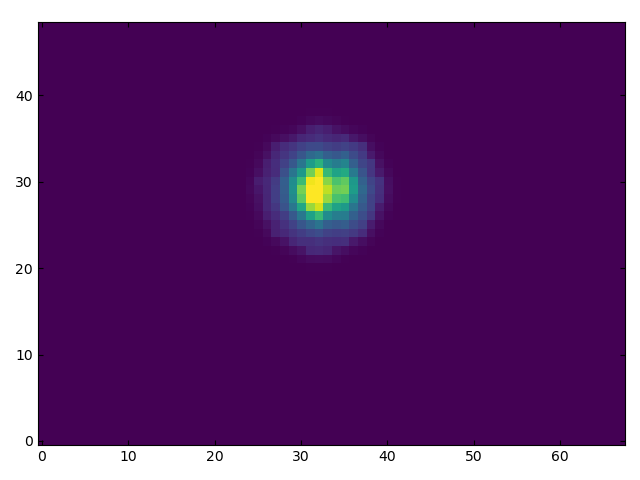

In [52]:
bfac_2D = np.zeros_like(data_vbin).astype('float')
indice0 = np.argwhere(data_vbin == nmax_bin)
for b in np.unique(data_vbin):
    indices = np.argwhere(data_vbin == b)
    diff = (indices - indice0)**2.
    maxdist = np.sqrt(np.sum(diff, axis=1)).max()
    if ((b == -99) | (maxdist > 7.1)):
#         ((maxdist > 9.) & (bfac[b] > 0.1*bfac[nmax_bin]))):
        bf = 0.0
    else:
        bf = bfac[b] / bfac[nmax_bin]
    bfac_2D[data_vbin == b] = bf

gs2d = Gaussian2DKernel(1, 1)
bf2 = convolve(bfac_2D, gs2d)
bfac_2D[bfac_2D == 0.] = bf2[bfac_2D == 0.]
bfac_2D[bfac_2D < 0.001] = 0.
    
fig, ax = plt.subplots()
ax.imshow(bfac_2D, origin = 'lower', vmin=0.0, vmax=0.8)
plt.tight_layout()
fits.writeto("bfac_bin_Ha.fits", bfac_2D, overwrite=True)

<IPython.core.display.Javascript object>


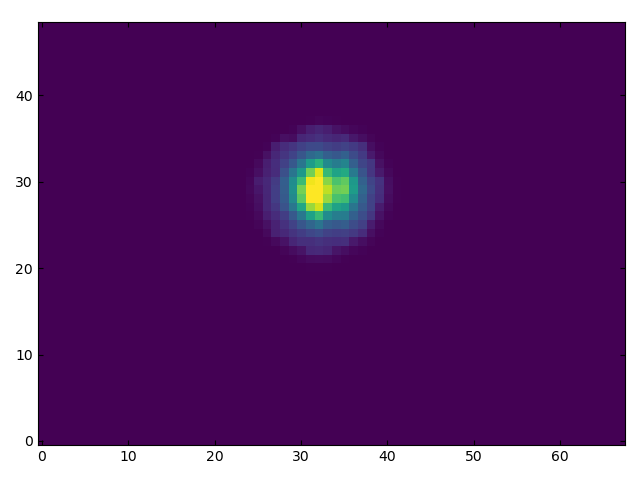

In [53]:
bfac_pix = np.zeros_like(data_vbin).astype('float')
for b in np.unique(data_vbin):
    bfac_pix[data_vbin == b] = bfac_2D[data_vbin == b] / np.sum(data_vbin == b)
        
fig, ax = plt.subplots()
ax.imshow(bfac_pix, origin = 'lower', vmin=0, vmax=0.8)
plt.tight_layout()
fits.writeto("bfac_pix_Ha.fits", bfac_pix, overwrite=True)

* ${\rm H\beta}+{\rm [OIII]\lambda\lambda4959,5007}$

In [54]:
bpar, e_bpar = [f1, f2, t1, t2_b, r1_b, r2_b, r3_b], [e_f1, e_f2, e_t1, e_t2_b, e_r1_b, e_r2_b, e_r3_b]

line_numbers = 6
nlines, nbroad = 10, 7
line_names = ['Hbeta', 'OIII4959', 'OIII5007', 'Broad6_1', 'Broad6_2', 'Broad6_3', 'Broad6_4',
              'Broad6_5', 'Broad6_6', 'Broad6_7']
line_wav = [4862.68, 4960.295, 5008.240]
line_sigma = [3.0]
wav_fit = [4800.0, 5040.0]
line_model = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nlines, n_broad=nbroad)

bfac = np.zeros(binned_spectrum.shape[1])
e_bfac = np.zeros(binned_spectrum.shape[1])
nmax_bin = data_vbin[yInd, xInd]
bfac[nmax_bin], e_bfac[nmax_bin] = 1.0, 0.0
print(f"Maximum - Bin {nmax_bin:d} : {bfac[0]:.3f} +/- {e_bfac[0]:.3f}")

for ibin in np.arange(binned_spectrum.shape[1]):
# ibin = 0
    fit_spectrum = dat[:, ibin]
    fit_variance = var[:, ibin]
    indices = np.argwhere(data_vbin == ibin)
    npix = indices.shape[0]
    fac = np.sum(img_g2d[indices[:, 0], indices[:, 1]]) / npix
    if (mode == "subcircular"):
        fac /= (np.sum(img_g2d*msk))


    spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
               np.abs(wav_res-wav_fit[1]).argmin()]
    x_bin = wav_res[1] - wav_res[0]
    x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
    x_fit = np.log(x_wav)

    y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
    y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
    y_dat = y_loc
    flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
    y_fit = x_wav * y_dat


    broad_fit = 0
    for i in np.arange(len(bpar)):
        mpar_b = bpar[i]
        broad_fit += gauss_cdf_scale(x_fit, *mpar_b)

    # Model fitting
    def line_model2(x, *pars):
        narrow_comp = 0
        for i in np.arange(nlines-nbroad):
            narrow_comp += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
        broad_comp = 10.**(pars[2*(nlines-nbroad)+1]) * broad_fit
        return narrow_comp + broad_comp

    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines-nbroad):
        param += [np.log(line_wav[j]), flx_scale0 / nlines]
    param += [np.log10(fac)]

    try:
        popt, pcov = curve_fit(line_model2, x_fit, y_fit, param)
        perr = np.sqrt(np.diag(pcov))

        bfac[ibin] = 10.**(np.maximum(-7.0, popt[-1]))
        e_bfac[ibin] = bfac[ibin] * np.log(10.0) * perr[-1]

    except RuntimeError:
        bfac[ibin] = np.maximum(0.0, param[-1])#*indices.shape[0]
        e_bfac[ibin] = 0.0

    print(f"Bin {ibin:d} : {bfac[ibin]:.3e} +/- {e_bfac[ibin]:.3e}")

Maximum - Bin 0 : 1.000 +/- 0.000
Bin 0 : 3.729e-02 +/- 2.668e-04
Bin 1 : 3.568e-02 +/- 2.465e-04
Bin 2 : 2.809e-02 +/- 2.541e-04
Bin 3 : 3.215e-02 +/- 2.963e-04
Bin 4 : 2.705e-02 +/- 2.607e-04
Bin 5 : 2.781e-02 +/- 2.525e-04
Bin 6 : 2.158e-02 +/- 2.513e-04
Bin 7 : 1.729e-02 +/- 3.062e-04
Bin 8 : 2.366e-02 +/- 2.958e-04
Bin 9 : 1.594e-02 +/- 2.230e-04
Bin 10 : 1.449e-02 +/- 2.466e-04
Bin 11 : 1.262e-02 +/- 1.883e-04
Bin 12 : 8.598e-03 +/- 2.396e-04
Bin 13 : 1.955e-02 +/- 2.451e-04
Bin 14 : 7.567e-03 +/- 1.685e-04
Bin 15 : 1.692e-02 +/- 2.436e-04
Bin 16 : 1.091e-02 +/- 1.723e-04
Bin 17 : 1.306e-02 +/- 2.335e-04
Bin 18 : 4.724e-03 +/- 2.233e-04
Bin 19 : 8.294e-03 +/- 2.162e-04
Bin 20 : 9.203e-03 +/- 1.515e-04
Bin 21 : 4.744e-03 +/- 1.667e-04
Bin 22 : 1.382e-02 +/- 2.088e-04
Bin 23 : 1.952e-02 +/- 1.420e-04
Bin 24 : 1.369e-02 +/- 1.262e-04
Bin 25 : 2.379e-02 +/- 1.444e-04
Bin 26 : 7.141e-03 +/- 1.863e-04
Bin 27 : 8.512e-03 +/- 2.624e-04
Bin 28 : 3.579e-03 +/- 2.073e-04
Bin 29 : 6.526e-03 

/home/jlee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in double_scalars


Bin 98 : 2.031e-03 +/- 5.994e-04
Bin 99 : 1.887e-03 +/- 4.782e-04
Bin 100 : 1.000e-07 +/- inf
Bin 101 : 6.044e-03 +/- 2.801e-04
Bin 102 : 1.000e-07 +/- inf
Bin 103 : 6.203e-03 +/- 4.256e-04
Bin 104 : 9.837e-03 +/- 2.467e-04
Bin 105 : 1.775e-03 +/- 8.506e-05
Bin 106 : 1.171e-03 +/- 7.987e-05
Bin 107 : 4.279e-03 +/- 4.779e-04
Bin 108 : 1.000e-07 +/- inf
Bin 109 : 2.166e-03 +/- 4.054e-04
Bin 110 : 3.118e-03 +/- 2.978e-04
Bin 111 : 1.209e-03 +/- 1.082e-04
Bin 112 : 2.997e-03 +/- 1.851e-04
Bin 113 : 1.000e-07 +/- inf
Bin 114 : 1.000e-07 +/- inf
Bin 115 : 1.000e-07 +/- 7.195e-03
Bin 116 : 1.000e-07 +/- inf
Bin 117 : 2.647e-03 +/- 4.416e-04
Bin 118 : 4.884e-03 +/- 1.581e-04
Bin 119 : 1.000e-07 +/- inf
Bin 120 : 1.000e-07 +/- inf
Bin 121 : 1.840e-03 +/- 2.511e-04
Bin 122 : 2.443e-03 +/- 1.229e-04
Bin 123 : 1.000e-07 +/- 1.833e-01
Bin 124 : 5.592e-03 +/- 2.703e-04
Bin 125 : 1.000e-07 +/- 6.299e-03
Bin 126 : 1.202e-03 +/- 8.196e-05
Bin 127 : 1.000e-07 +/- inf
Bin 128 : 1.000e-07 +/- inf
Bin 129 

Bin 351 : 2.077e-03 +/- 1.714e-04
Bin 352 : 6.319e-04 +/- 1.647e-04
Bin 353 : 7.231e-03 +/- 1.721e-04
Bin 354 : 3.683e-03 +/- 1.454e-04
Bin 355 : 1.000e-07 +/- inf
Bin 356 : 4.608e-03 +/- 1.669e-04
Bin 357 : 9.991e-04 +/- 2.878e-04
Bin 358 : 7.036e-04 +/- 1.732e-04
Bin 359 : 1.000e-07 +/- 4.081e-02
Bin 360 : 2.968e-03 +/- 1.724e-04
Bin 361 : 4.718e-03 +/- 1.104e-04
Bin 362 : 1.000e-07 +/- inf
Bin 363 : 1.000e-07 +/- inf
Bin 364 : 1.032e-02 +/- 3.838e-04
Bin 365 : 1.224e-03 +/- 1.667e-04
Bin 366 : 4.583e-04 +/- 1.218e-04
Bin 367 : 1.471e-02 +/- 1.091e-03
Bin 368 : 4.212e-03 +/- 1.595e-04
Bin 369 : 1.923e-02 +/- 6.988e-04
Bin 370 : 4.003e-03 +/- 8.292e-05
Bin 371 : 2.276e-03 +/- 1.370e-04
Bin 372 : 2.337e-03 +/- 1.960e-04
Bin 373 : 3.735e-04 +/- 1.601e-04
Bin 374 : 1.011e-02 +/- 3.485e-04
Bin 375 : 2.295e-03 +/- 1.604e-04
Bin 376 : 1.000e-07 +/- inf
Bin 377 : 8.955e-05 +/- 1.686e-04
Bin 378 : 2.707e-03 +/- 1.726e-04
Bin 379 : 9.164e-04 +/- 1.871e-04
Bin 380 : 1.039e-03 +/- 1.251e-04
Bin 

<IPython.core.display.Javascript object>


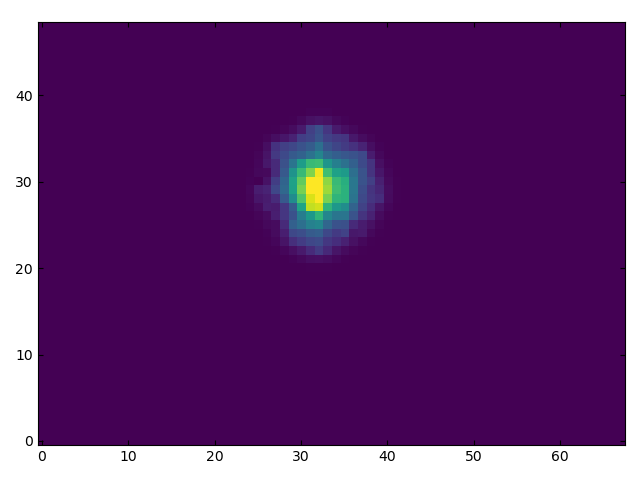

In [55]:
bfac_2D = np.zeros_like(data_vbin).astype('float')
indice0 = np.argwhere(data_vbin == nmax_bin)
for b in np.unique(data_vbin):
    indices = np.argwhere(data_vbin == b)
    diff = (indices - indice0)**2.
    maxdist = np.sqrt(np.sum(diff, axis=1)).max()
    if ((b == -99) | (maxdist > 7.1)):
#         ((maxdist > 9.) & (bfac[b] > 0.1*bfac[nmax_bin]))):
        bf = 0.0
    else:
        bf = bfac[b] / bfac[nmax_bin]
    bfac_2D[data_vbin == b] = bf

gs2d = Gaussian2DKernel(1, 1)
bf2 = convolve(bfac_2D, gs2d)
bfac_2D[bfac_2D == 0.] = bf2[bfac_2D == 0.]
bfac_2D[bfac_2D < 0.001] = 0.
    
fig, ax = plt.subplots()
ax.imshow(bfac_2D, origin = 'lower', vmin=0.0, vmax=0.8)
plt.tight_layout()
fits.writeto("bfac_bin_Hb.fits", bfac_2D, overwrite=True)

<IPython.core.display.Javascript object>


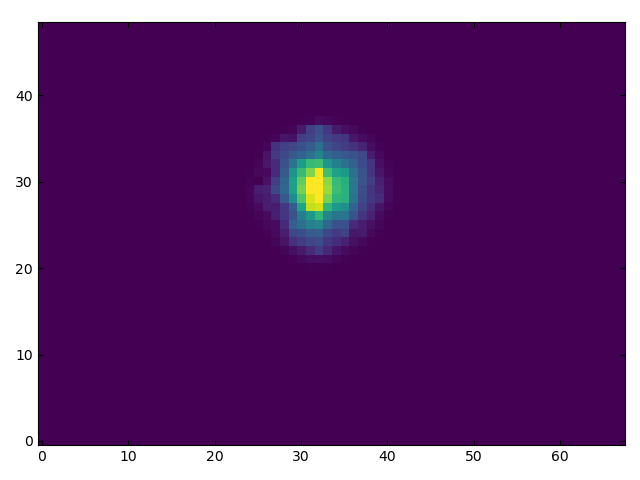

In [56]:
bfac_pix = np.zeros_like(data_vbin).astype('float')
for b in np.unique(data_vbin):
    bfac_pix[data_vbin == b] = bfac_2D[data_vbin == b] / np.sum(data_vbin == b)
        
fig, ax = plt.subplots()
ax.imshow(bfac_pix, origin = 'lower', vmin=0, vmax=0.8)
plt.tight_layout()
fits.writeto("bfac_pix_Hb.fits", bfac_pix, overwrite=True)